
# SmartFootPrintAI — OFF→LCA→FAOSTAT → **Q ** Recalculation
**Scope:** This notebook builds a *region-agnostic* environmental extension **Q_new** for EXIOBASE sectors using:
- Cached product→Clark (`cache_offcanon_to_clark.parquet`) and product→FAOSTAT (`cache_offcanon_to_fao.parquet`) mappings,
- Clark et al. (2022) LCA table (per-kg impacts),
- FAOSTAT prices (USD/kg → EUR/kg),
- Product→EXIO sector top‑1 mapping (`product_to_sector_mapping_top1_corrected.parquet`).

We output:
1. A product-level table (per-kg + per-€ for **CO2, Land, Water**),
2. A sector-level **Q_new** (3 × N_sectors; **no regions**), strictly unit-consistent,
3. Diagnostics + (optional) comparison vs an **old** regioned Q (aggregated across regions).

**We do *not* recompute Leontief inverse here.**


## 0) Environment & packages

In [1]:

# Intent:
# - Keep dependencies minimal and reproducible in Colab.
# - Avoid zarrita/zarr v3 issues entirely.
# - Ensure Parquet support for reading cached maps.
#
# Notes:
# - If running on Colab, pandas/numpy/tqdm are preinstalled; install pyarrow for parquet.

import sys, os, random, math, warnings
warnings.filterwarnings("ignore")

# (Colab) install pyarrow for parquet support if needed
try:
    import pyarrow  # noqa
except Exception:
    !pip -q install pyarrow

import numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# Determinism
random.seed(42)
np.random.seed(42)

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)


## 1) Paths & configuration

In [7]:

# Intent:
# - Mount Google Drive and define robust paths.
# - Make all file paths easy to override via a single ROOT folder.
# - Enforce indicator canonical names and units (CO2 kg, Land m^2, Water m^3; Price EUR/kg).

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

# === Project root (edit if needed) ===
ROOT = input("Enter project root (default: /content/drive/MyDrive/MRIO_3/SmartFootPrintAI): ").strip()
if not ROOT:
    ROOT = "/content/drive/MyDrive/MRIO_3/SmartFootPrintAI"
ROOT = Path(ROOT)
ROOT.mkdir(parents=True, exist_ok=True)

# === Inputs (user-provided) ===
# Cached mapping files (already computed elsewhere; we DO NOT remap here)
PATH_CACHE_CLARK = "/content/drive/MyDrive/cache_offcanon_to_clark.parquet"
PATH_CACHE_FAO   = "/content/drive/MyDrive/cache_offcanon_to_fao.parquet"

# OFF → EXIO sector (top‑1, corrected)
PATH_TOP1_SECTOR = ROOT / "product_to_sector_mapping_top1_corrected.parquet"

# LCA & FAOSTAT
PATH_LCA_CLARK   = ROOT / "Environmental impacts of food (Clark et al. 2022).csv"
PATH_FAOSTAT_CSV = ROOT / "FAOSTAT_data_en_8-22-2025.csv"

# Optional: baseline MRIO Q (regioned) for comparison
# Provide either CSV or NPY path for Q_old with shapes like:
#   - CSV (wide): rows=sectors, columns=multiindex or 3×(R×S); or
#   - NPY: shape = (3, R, S) or (R, S, 3) — detection is automatic.
PATH_Q_OLD_OPT   = ROOT / "Q_old_regioned.npy"   # change if you have a known file
PATH_SECTORS_OPT = ROOT / "Sectors.xlsx"        # optional sector list in correct EXIO order

# === Outputs ===
OUT_DIR   = ROOT / "harmonized_micro"
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PRODUCTS  = OUT_DIR / "products_normalized_units.csv"
OUT_SECTORS   = OUT_DIR / "sector_level_micro_extension.csv"
OUT_Q_NEW_CSV = OUT_DIR / "Q_new_regionless.csv"
OUT_Q_NEW_NPY = OUT_DIR / "Q_new_regionless.npy"
OUT_Q_DIFF    = OUT_DIR / "Q_new_vs_Qold_agg.csv"

# === Settings ===
USD_TO_EUR = float(input("USD→EUR rate (default 0.90): ") or 0.90)
PRICE_TRIM_QUANTILES = (0.01, 0.99)  # robust trimming for extreme FAOSTAT price outliers

# Canonical indicators; order is fixed
INDICATORS = ["CO2", "Land", "Water"]
assert len(INDICATORS) == 3 and INDICATORS[0]=="CO2" and INDICATORS[1]=="Land" and INDICATORS[2]=="Water"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter project root (default: /content/drive/MyDrive/MRIO_3/SmartFootPrintAI): /content/drive/MyDrive/MRIO_3/SmartFootPrintAI
USD→EUR rate (default 0.90): 0.90


## 2) Helper utilities (schema sniffers, cleaners, unit ops)

In [4]:

# Intent:
# - Provide robust functions that handle column-name drift.
# - Normalize strings for joining.
# - Convert units with explicit formulas and checks.

import re, unicodedata

def norm_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("ascii")
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def pick(df: pd.DataFrame, candidates, default=None):
    low = {c.lower(): c for c in df.columns}
    for name in candidates:
        k = name.lower()
        if k in low:
            return low[k]
    # pattern fallback
    for c in df.columns:
        cl = c.lower()
        for name in candidates:
            if isinstance(name, str) and name.lower() in cl:
                return c
    return default

def wavg(values, weights):
    v = np.asarray(values, float)
    w = np.asarray(weights, float)
    m = np.isfinite(v) & np.isfinite(w) & (w > 0)
    return float(np.average(v[m], weights=w[m])) if m.any() else np.nan

def trim_outliers(s: pd.Series, q=(0.01,0.99)):
    lo, hi = s.quantile(q[0]), s.quantile(q[1])
    return s.clip(lower=lo, upper=hi)

def assert_nonnegative(name, arr):
    if np.nanmin(arr) < 0:
        raise ValueError(f"{name} contains negative values, which is not expected in this context.")

def sanity_print(title, df, n=8):
    print(f"\n— {title} —")
    display(df.head(n))
    print(f"shape={df.shape}; columns={list(df.columns)[:12]}...")



## 3) Load mappings + LCA (Clark) + FAOSTAT, normalize to per‑kg and per‑€

In [12]:

# Intent:
# - Use *cached* OFF→Clark and OFF→FAOSTAT maps (no fuzzy/semantic matching here).
# - Normalize Clark to:
#     CO2_per_kg [kg/kg], Land_per_kg [m^2/kg], Water_per_kg [m^3/kg].
# - Build FAOSTAT EUR/kg from any USD/kg or USD/100kg row;
#   handle multiple rows/years by taking the most recent and trimming outliers.
# - Merge with product→EXIO sector top‑1.

# Intent:
# - Prefer a consolidated, pre-merged file if provided: products_with_lca_price_sector_mapped.parquet
#   (should contain product_key, sector_name, LCA per-kg, prices, etc.).
# - Analyze that file first (shape, columns, dtypes, NaNs), enforce units:
#     CO2_per_kg [kg/kg], Land_per_kg [m^2/kg], Water_per_kg [m^3/kg], Price [EUR/kg]
#     and derived per-€: *_per_eur = *_per_kg / eur_per_kg
# - If the consolidated file is missing or incomplete, fall back to:
#     cache_offcanon_to_clark.parquet + cache_offcanon_to_fao.parquet + Clark CSV + FAOSTAT CSV
# - Save normalized product table to OUT_PRODUCTS.

# Intent:
# - Use ONLY the consolidated, pre-merged file: products_with_lca_price_sector_mapped.parquet
#   (contains product_key, sector_name, LCA per-kg, prices, etc.)
# - Analyze it, standardize units to:
#     CO2_per_kg [kg/kg], Land_per_kg [m^2/kg], Water_per_kg [m^3/kg], Price [EUR/kg]
#   and derive per-€: *_per_eur = *_per_kg / eur_per_kg
# - If sector_name is missing, join from top-1 corrected mapping parquet.
# - Save normalized product table → OUT_PRODUCTS.
#
# Absolutely NO use of cache_offcanon_to_clark.parquet or remapping steps.

import os, re, numpy as np, pandas as pd

# ---- Candidate locations for the consolidated file ----
CANDIDATE_READY_PATHS = [
    ROOT / "products_with_lca_price_sector_mapped.parquet",
    Path("/mnt/data/products_with_lca_price_sector_mapped.parquet"),
    Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI/products_with_lca_price_sector_mapped.parquet"),
]

def _find_ready_file(paths):
    for p in paths:
        if isinstance(p, (str, os.PathLike)):
            p = Path(p)
        if p.exists():
            return p
    return None

def _report_df(df: pd.DataFrame, title="DataFrame", n=8):
    print(f"\n— {title} —")
    print(f"shape={df.shape}")
    print("columns:", list(df.columns))
    display(df.head(n))
    print("dtypes:", {c:str(t) for c,t in df.dtypes.items()})

def _pick(df: pd.DataFrame, candidates, default=None):
    return pick(df, candidates, default)   # uses earlier helper

def _norm_text_local(s: str) -> str:
    return norm_text(s)

def normalize_product_table(df_raw: pd.DataFrame) -> pd.DataFrame:
    """Standardize to:
       - product_key (str, normalized)
       - sector_name (str, normalized; joined from TOP1 if missing)
       - weight in [0,1] (use final_score/weight if present, else 1.0)
       - co2_per_kg [kg/kg], land_per_kg [m^2/kg], water_per_kg [m^3/kg]
       - eur_per_kg [€/kg]
       - co2_per_eur, land_per_eur, water_per_eur
    """
    df = df_raw.copy()

    # ---- Identify key columns (robust sniffers) ----
    prod_col   = _pick(df, ["product_key","product","product_text","canonical_name","off_canon"])
    sect_col   = _pick(df, ["sector_name","sector","exio_sector","exio_name"])
    weight_col = _pick(df, ["weight","final_score"])

    co2kg_col  = _pick(df, ["co2_per_kg","ghg_per_kg","ghg_kg"])
    landkg_col = _pick(df, ["land_per_kg","land_m2_per_kg","land_use_m2_per_kg","land_use_kg","land m2"])
    w_m3_kg    = _pick(df, ["water_per_kg","water_m3_per_kg"])     # m^3/kg variants
    w_L_kg     = _pick(df, ["water_l_per_kg","water_l"])           # liters/kg variants

    eurkg_col  = _pick(df, ["eur_per_kg","price_eur_per_kg"])
    usdkg_col  = _pick(df, ["usd_per_kg","price_usd_per_kg"])
    unit_col   = _pick(df, ["unit","unit_price"])
    curr_col   = _pick(df, ["currency"])

    if prod_col is None:
        raise ValueError("Consolidated file must have a product key column (e.g., 'product_key').")

    # ---- Normalize keys ----
    df = df.rename(columns={prod_col: "product_key"})
    df["product_key"] = df["product_key"].astype(str).map(_norm_text_local)

    if sect_col is not None:
        df = df.rename(columns={sect_col: "sector_name"})
        df["sector_name"] = df["sector_name"].astype(str).map(_norm_text_local)

    # ---- Weight / confidence in [0,1] ----
    if weight_col and weight_col in df.columns:
        df["weight"] = pd.to_numeric(df[weight_col], errors="coerce").clip(lower=0, upper=1)
    else:
        df["weight"] = 1.0

    # ---- LCA per-kg normalization ----
    # CO2 per kg: kg/kg
    if co2kg_col and co2kg_col in df.columns:
        df["co2_per_kg"] = pd.to_numeric(df[co2kg_col], errors="coerce")
    elif "co2_per_kg" not in df.columns:
        df["co2_per_kg"] = np.nan

    # Land per kg: m^2/kg
    if landkg_col and landkg_col in df.columns:
        df["land_per_kg"] = pd.to_numeric(df[landkg_col], errors="coerce")
    elif "land_per_kg" not in df.columns:
        df["land_per_kg"] = np.nan

    # Water per kg: prefer m^3/kg; if only liters/kg present, convert → m^3/kg
    if w_m3_kg and w_m3_kg in df.columns:
        df["water_per_kg"] = pd.to_numeric(df[w_m3_kg], errors="coerce")
    elif w_L_kg and w_L_kg in df.columns:
        df["water_per_kg"] = pd.to_numeric(df[w_L_kg], errors="coerce") / 1000.0
    else:
        if "water_per_kg" in df.columns:
            df["water_per_kg"] = pd.to_numeric(df["water_per_kg"], errors="coerce")
            # auto-detect liters by magnitude
            if df["water_per_kg"].median(skipna=True) > 100:
                df["water_per_kg"] = df["water_per_kg"] / 1000.0
        else:
            df["water_per_kg"] = np.nan

    # ---- Price to EUR/kg ----
    # Use EUR/kg if present; else USD/kg * USD_TO_EUR; else try generic price + currency
    if eurkg_col and eurkg_col in df.columns:
        df["eur_per_kg"] = pd.to_numeric(df[eurkg_col], errors="coerce")
    elif usdkg_col and usdkg_col in df.columns:
        df["eur_per_kg"] = pd.to_numeric(df[usdkg_col], errors="coerce") * float(USD_TO_EUR)
    else:
        if "price" in df.columns:
            p = pd.to_numeric(df["price"], errors="coerce")
            unit = (df[unit_col] if unit_col in df.columns else "").astype(str).str.lower()
            curr = (df[curr_col] if curr_col in df.columns else "").astype(str).str.lower()
            eur_guess = np.where(curr.str.contains("eur"), p,
                           np.where(curr.str.contains("usd"), p * float(USD_TO_EUR), np.nan))
            # assume per kg unless otherwise specified
            df["eur_per_kg"] = eur_guess
        else:
            df["eur_per_kg"] = np.nan

    # ---- Derived per-€ intensities ----
    for base in ["co2","land","water"]:
        per_kg  = f"{base}_per_kg"
        per_eur = f"{base}_per_eur"
        df[per_eur] = np.where(df["eur_per_kg"] > 0, df[per_kg] / df["eur_per_kg"], np.nan)

    # ---- If sector is missing, join from TOP1 mapping ----
    if ("sector_name" not in df.columns) or df["sector_name"].isna().all():
        if not PATH_TOP1_SECTOR.exists():
            print("[warn] sector_name missing and top-1 mapping parquet not found; sectors will remain NaN.")
        else:
            topo = pd.read_parquet(PATH_TOP1_SECTOR)
            topo_prod = _pick(topo, ["product_key","product","product_text","canonical_name","off_canon"])
            topo_sec  = _pick(topo, ["sector_name","sector","exio_sector","exio_name"])
            if topo_prod is None or topo_sec is None:
                print("[warn] top-1 parquet lacks needed columns; sectors will remain NaN.")
            else:
                topo = topo.rename(columns={topo_prod:"product_key", topo_sec:"sector_name"})
                topo["product_key"] = topo["product_key"].astype(str).map(_norm_text_local)
                topo["sector_name"] = topo["sector_name"].astype(str).map(_norm_text_local)
                df = df.merge(topo[["product_key","sector_name"]], on="product_key", how="left")

    # ---- Final selection / order ----
    out_cols = ["product_key","sector_name","weight",
                "co2_per_kg","land_per_kg","water_per_kg",
                "eur_per_kg","co2_per_eur","land_per_eur","water_per_eur"]
    for c in out_cols:
        if c not in df.columns:
            df[c] = np.nan

    df = df[out_cols].drop_duplicates().reset_index(drop=True)

    # ---- QA ----
    _report_df(df, title="Consolidated (normalized) product table preview")
    print(f"% rows missing eur_per_kg: {100*df['eur_per_kg'].isna().mean():.1f}%")
    for base in ["co2","land","water"]:
        k = f"{base}_per_kg"
        print(f"{k}: non-null {df[k].notna().sum()} / {len(df)}")

    return df

# ---- 1) Locate and load the consolidated file ----
ready_path = _find_ready_file(CANDIDATE_READY_PATHS)
if ready_path is None:
    raise FileNotFoundError(
        "products_with_lca_price_sector_mapped.parquet not found in expected locations.\n"
        f"Tried: {CANDIDATE_READY_PATHS}"
    )

# Ensure parquet IO is available in Colab
try:
    _df_test = pd.read_parquet(ready_path)
except Exception:
    print("Installing parquet dependencies (pyarrow)…")
    !pip -q install pyarrow
    _df_test = pd.read_parquet(ready_path)

print("Loading consolidated product file:", ready_path)
raw_ready = pd.read_parquet(ready_path)
_report_df(raw_ready, title="Consolidated input (raw)")
prod = normalize_product_table(raw_ready)

# ---- 2) Save normalized product table ----
sanity_print("Product-level (normalized units)", prod)
prod.to_csv(OUT_PRODUCTS, index=False)
print(f"✅ Saved product-level normalized table → {OUT_PRODUCTS}")



Loading consolidated product file: /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/products_with_lca_price_sector_mapped.parquet

— Consolidated input (raw) —
shape=(331953, 16)
columns: ['off_canon', 'off_name', 'sector_name', 'match_canon', 'score', 'accepted', 'co2_per_kg', 'land_per_kg', 'water_per_kg', 'match_canon_fao', 'score_fao', 'accepted_fao', 'usd_per_kg', 'co2_per_usd', 'land_per_usd', 'water_per_usd']


,off_canon,off_name,sector_name,match_canon,score,accepted,co2_per_kg,land_per_kg,water_per_kg,match_canon_fao,score_fao,accepted_fao,usd_per_kg,co2_per_usd,land_per_usd,water_per_usd
0,chocolate bear crunch popcorn oh sugar milk ch...,chocolate bear crunch popcorn oh sugar! ...,sugar refining,almonds,100.000000,True,0.602368,8.230927,372799.101063,anise badian coriander cumin caraway fennel an...,85.5,True,2.75960,0.218281,2.982652,135091.716576
1,chocolate gems oh sugar milk chocolate sugar c...,"!, chocolate gems oh sugar milk chocolat...","cultivation of sugar cane, sugar beet",butter,100.000000,True,3.324503,3.619797,6142.515252,anise badian coriander cumin caraway fennel an...,85.5,True,2.75960,1.204705,1.311711,2225.871594
2,fresh soda ginger wisco pop sparkling filtered...,"!, fresh soda, ginger wisco pop sparklin...",manufacture of beverages,lemons,83.333333,True,0.470153,0.611375,9155.021509,edible roots and tubers with high starch or in...,85.5,True,1.32650,0.354431,0.460893,6901.637022
3,gummie flower oh sugar corn syrup sugar gelati...,"!, gummie flower oh sugar corn syrup, su...",processing vegetable oils and fats,sugar,100.000000,True,1.851686,2.153669,11123.746327,agave fibres raw n e c,85.5,True,0.99000,1.870390,2.175424,11236.107401
4,halloween mix whole wheat cookies bite me suga...,"!, halloween mix whole wheat cookies bite me...",raw milk,butter,100.000000,True,3.324503,3.619797,6142.515252,wheat,100.0,True,0.34040,9.766461,10.633950,18044.991926
5,happy birthday sour jelly beans oh sugar sugar...,"!, happy birthday sour jelly beans oh sugar ...","cultivation of sugar cane, sugar beet",beans,100.000000,True,1.373308,17.068111,0.693874,beeswax,100.0,True,5.08715,0.269956,3.355142,0.136397
6,happy halloween gummy worms oh sugar syrup fro...,"!, happy halloween! gummy worms oh sugar ...",sugar refining,sugar,100.000000,True,1.851686,2.153669,11123.746327,anise badian coriander cumin caraway fennel an...,85.5,True,2.75960,0.670998,0.780428,4030.927065
7,malted milk balls oh sugar gki choc malted mil...,"!, malted milk balls oh sugar gki choc m...",raw milk,milk chocolate,100.000000,True,10.800275,17.273874,8151.760939,palm oil,100.0,True,1.23040,8.777857,14.039234,6625.293351


dtypes: {'off_canon': 'object', 'off_name': 'object', 'sector_name': 'object', 'match_canon': 'object', 'score': 'float64', 'accepted': 'bool', 'co2_per_kg': 'float64', 'land_per_kg': 'float64', 'water_per_kg': 'float64', 'match_canon_fao': 'object', 'score_fao': 'float64', 'accepted_fao': 'bool', 'usd_per_kg': 'float64', 'co2_per_usd': 'float64', 'land_per_usd': 'float64', 'water_per_usd': 'float64'}

— Consolidated (normalized) product table preview —
shape=(331947, 10)
columns: ['product_key', 'sector_name', 'weight', 'co2_per_kg', 'land_per_kg', 'water_per_kg', 'eur_per_kg', 'co2_per_eur', 'land_per_eur', 'water_per_eur']


,product_key,sector_name,weight,co2_per_kg,land_per_kg,water_per_kg,eur_per_kg,co2_per_eur,land_per_eur,water_per_eur
0,chocolate bear crunch popcorn oh sugar milk ch...,sugar refining,1.0,0.602368,8.230927,372799.101063,2.483640,0.242534,3.314058,150101.907307
1,chocolate gems oh sugar milk chocolate sugar c...,"cultivation of sugar cane, sugar beet",1.0,3.324503,3.619797,6142.515252,2.483640,1.338561,1.457456,2473.190660
2,fresh soda ginger wisco pop sparkling filtered...,manufacture of beverages,1.0,0.470153,0.611375,9155.021509,1.193850,0.393812,0.512104,7668.485580
3,gummie flower oh sugar corn syrup sugar gelati...,processing vegetable oils and fats,1.0,1.851686,2.153669,11123.746327,0.891000,2.078211,2.417137,12484.563779
4,halloween mix whole wheat cookies bite me suga...,raw milk,1.0,3.324503,3.619797,6142.515252,0.306360,10.851623,11.815501,20049.991029
5,happy birthday sour jelly beans oh sugar sugar...,"cultivation of sugar cane, sugar beet",1.0,1.373308,17.068111,0.693874,4.578435,0.299951,3.727936,0.151553
6,happy halloween gummy worms oh sugar syrup fro...,sugar refining,1.0,1.851686,2.153669,11123.746327,2.483640,0.745553,0.867142,4478.807849
7,malted milk balls oh sugar gki choc malted mil...,raw milk,1.0,10.800275,17.273874,8151.760939,1.107360,9.753174,15.599149,7361.437057


dtypes: {'product_key': 'object', 'sector_name': 'object', 'weight': 'float64', 'co2_per_kg': 'float64', 'land_per_kg': 'float64', 'water_per_kg': 'float64', 'eur_per_kg': 'float64', 'co2_per_eur': 'float64', 'land_per_eur': 'float64', 'water_per_eur': 'float64'}
% rows missing eur_per_kg: 0.0%
co2_per_kg: non-null 331935 / 331947
land_per_kg: non-null 331935 / 331947
water_per_kg: non-null 331935 / 331947

— Product-level (normalized units) —


,product_key,sector_name,weight,co2_per_kg,land_per_kg,water_per_kg,eur_per_kg,co2_per_eur,land_per_eur,water_per_eur
0,chocolate bear crunch popcorn oh sugar milk ch...,sugar refining,1.0,0.602368,8.230927,372799.101063,2.483640,0.242534,3.314058,150101.907307
1,chocolate gems oh sugar milk chocolate sugar c...,"cultivation of sugar cane, sugar beet",1.0,3.324503,3.619797,6142.515252,2.483640,1.338561,1.457456,2473.190660
2,fresh soda ginger wisco pop sparkling filtered...,manufacture of beverages,1.0,0.470153,0.611375,9155.021509,1.193850,0.393812,0.512104,7668.485580
3,gummie flower oh sugar corn syrup sugar gelati...,processing vegetable oils and fats,1.0,1.851686,2.153669,11123.746327,0.891000,2.078211,2.417137,12484.563779
4,halloween mix whole wheat cookies bite me suga...,raw milk,1.0,3.324503,3.619797,6142.515252,0.306360,10.851623,11.815501,20049.991029
5,happy birthday sour jelly beans oh sugar sugar...,"cultivation of sugar cane, sugar beet",1.0,1.373308,17.068111,0.693874,4.578435,0.299951,3.727936,0.151553
6,happy halloween gummy worms oh sugar syrup fro...,sugar refining,1.0,1.851686,2.153669,11123.746327,2.483640,0.745553,0.867142,4478.807849
7,malted milk balls oh sugar gki choc malted mil...,raw milk,1.0,10.800275,17.273874,8151.760939,1.107360,9.753174,15.599149,7361.437057


shape=(331947, 10); columns=['product_key', 'sector_name', 'weight', 'co2_per_kg', 'land_per_kg', 'water_per_kg', 'eur_per_kg', 'co2_per_eur', 'land_per_eur', 'water_per_eur']...
✅ Saved product-level normalized table → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/products_normalized_units.csv


In [15]:
# ============================================================
# Unit Audit (Clark & FAOSTAT) + Sector-only EXIO Baseline Prep
# ============================================================
# What this cell does:
# A) Re-derive units from raw columns (deterministic, no guessing)
#    - Clark indicators: CO2 (kg/kg), Land (m^2*year/kg), Water (L/kg) -> convert to m^3/kg
#    - FAOSTAT prices: Producer Price (USD/tonne) -> divide by 1000 -> USD/kg -> EUR/kg using USD_TO_EUR
# B) Validate your normalized product table:
#    - Verify *_per_eur == *_per_kg / eur_per_kg
#    - Null checks & value sanity
# C) Prepare sector-only q^{EXIO,global} baseline (optional):
#    - Load Q_old (3 × R × S) and outputs X (R × S) if provided
#    - Output-weight aggregate across regions; rescale per M€ → per € if needed
#
# Inputs (assumed or optional):
# - OUT_PRODUCTS  : normalized products table (CSV) with per-kg, EUR/kg, and per-€ columns
# - PATH_FAOSTAT_CSV: FAOSTAT Producer Price CSV (USD/tonne)
# - USD_TO_EUR    : FX rate (float)
# - Optional: PATH_Q_OLD_OPT (NPY) with shape (3,R,S) or (R,S,3) or (19,R,S)
# - Optional: PATH_X_OLD_OPT (NPY/CSV) sector outputs (R×S) in EUR or M€
#
# Outputs:
# - Printed unit summary + QA
# - (Optional) /harmonized_micro/Q_old_global_regionless.csv (sector-only EXIO baseline, per €)
# ============================================================

import os, re, json, numpy as np, pandas as pd
from pathlib import Path

# ---- Resolve paths & fallbacks ----
try:
    ROOT
except NameError:
    ROOT = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")

try:
    OUT_DIR
except NameError:
    OUT_DIR = ROOT / "harmonized_micro"
    OUT_DIR.mkdir(parents=True, exist_ok=True)

try:
    OUT_PRODUCTS
except NameError:
    # fallback to common locations
    OUT_PRODUCTS = OUT_DIR / "products_normalized_units.csv"
    if not OUT_PRODUCTS.exists():
        alt = Path("/mnt/data/products_normalized_units.csv")
        OUT_PRODUCTS = alt if alt.exists() else OUT_PRODUCTS

try:
    PATH_FAOSTAT_CSV
except NameError:
    PATH_FAOSTAT_CSV = ROOT / "FAOSTAT_data_en_8-22-2025.csv"

try:
    USD_TO_EUR
except NameError:
    USD_TO_EUR = 0.90  # fallback default

# Optional old Q & X (outputs)
try:
    PATH_Q_OLD_OPT
except NameError:
    PATH_Q_OLD_OPT = ROOT / "Q_old_regioned.npy"  # set your actual path if you have it

PATH_X_OLD_OPT = ROOT / "X_regioned.npy"         # optional (R×S); change if you have another file
OUT_Q_OLD_GLOBAL = OUT_DIR / "Q_old_global_regionless.csv"

# ---- A) Strict FAOSTAT unit logic (USD/tonne → EUR/kg) & Clark units ----
unit_summary = {}

# FAOSTAT read (if available)
fao_status = {"available": False}
if Path(PATH_FAOSTAT_CSV).exists():
    fao = pd.read_csv(PATH_FAOSTAT_CSV)
    unit_col = next((c for c in fao.columns if c.lower()=="unit"), None)
    elem_col = next((c for c in fao.columns if c.lower()=="element"), None)
    item_col = next((c for c in fao.columns if c.lower()=="item"), None)
    year_col = next((c for c in fao.columns if c.lower()=="year"), None)

    # Confirm official unit & element
    if unit_col and elem_col:
        # e.g., Unit == "USD", Element == "Producer Price (USD/tonne)"
        # The "USD/tonne" is often encoded in the Element text, while Unit is the currency.
        elems = fao[elem_col].dropna().astype(str).unique().tolist()
        units = fao[unit_col].dropna().astype(str).unique().tolist()
        fao_status.update({
            "available": True,
            "example_element": elems[:3],
            "example_unit": units[:3],
            "logic": "Producer Price (USD/tonne) -> /1000 => USD/kg -> × USD_TO_EUR => EUR/kg"
        })
    else:
        fao_status["warning"] = "Could not find Element/Unit columns; cannot confirm official units."
else:
    fao_status["warning"] = f"FAOSTAT file not found at {PATH_FAOSTAT_CSV}"

# Clark read (if available)
# Expect columns like: 'ghg_kg' (kg CO2e/kg); 'land_use_kg' (m^2*year/kg); 'water_kg' (liters/kg)
# We convert Water: L/kg → m^3/kg by dividing by 1000.
clark_status = {"available": False}
clark_candidates = [p for p in os.listdir("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI") if "Environmental impacts of food (Clark et al. 2022)" in p and p.endswith(".csv")]
if not clark_candidates:
    # also check /mnt/data if provided there
    clark_candidates = [p for p in os.listdir("/mnt/data") if "Environmental impacts of food (Clark et al. 2022)" in p and p.endswith(".csv")]
if clark_candidates:
    try:
        cpath = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI") / clark_candidates[0]
        if not cpath.exists():
            cpath = Path("/mnt/data") / clark_candidates[0]
        clark = pd.read_csv(cpath)
        cols = list(clark.columns)
        clark_status.update({
            "available": True,
            "path": str(cpath),
            "has_ghg_kg": any(c.lower()=="ghg_kg" for c in cols),
            "has_land_use_kg": any(c.lower()=="land_use_kg" for c in cols),
            "has_water_kg": any(c.lower()=="water_kg" for c in cols),
            "water_unit_raw": "liters per kg (L/kg); convert to m^3/kg via ÷1000",
            "land_unit_raw": "m^2·year per kg",
            "co2_unit_raw": "kg CO2e per kg"
        })
    except Exception as e:
        clark_status["warning"] = f"Failed to read Clark CSV: {e}"
else:
    clark_status["warning"] = "Clark CSV not found in project root or /mnt/data."

unit_summary["FAOSTAT"] = fao_status
unit_summary["Clark"]   = clark_status
unit_summary["USD_TO_EUR_used"] = float(USD_TO_EUR)

# ---- B) Validate your normalized product table ----
qa = {"exists": False}
if Path(OUT_PRODUCTS).exists():
    prod = pd.read_csv(OUT_PRODUCTS)
    qa["exists"] = True
    # 1) Required columns present?
    required = ["co2_per_kg","land_per_kg","water_per_kg","eur_per_kg",
                "co2_per_eur","land_per_eur","water_per_eur"]
    qa["missing_required_cols"] = [c for c in required if c not in prod.columns]

    # 2) Identity checks: per_€ == per_kg / (EUR/kg)
    id_checks = {}
    for base in ["co2","land","water"]:
        per_kg, per_eur = f"{base}_per_kg", f"{base}_per_eur"
        if per_kg in prod.columns and per_eur in prod.columns and "eur_per_kg" in prod.columns:
            resid = prod[per_kg] / prod["eur_per_kg"] - prod[per_eur]
            id_checks[base] = {
                "abs_median_residual": float(resid.abs().median(skipna=True)),
                "max_abs_residual": float(resid.abs().max(skipna=True)),
                "nan_share": float(resid.isna().mean()*100.0)
            }
    qa["per_eur_identity"] = id_checks

    # 3) NaN shares
    na_shares = {c: float(prod[c].isna().mean()*100.0) for c in required if c in prod.columns}
    qa["nan_share_%"] = na_shares

    # 4) Value sanity: all nonnegative (allow NaN)
    nonneg = {}
    for c in ["co2_per_kg","land_per_kg","water_per_kg","eur_per_kg",
              "co2_per_eur","land_per_eur","water_per_eur"]:
        if c in prod.columns:
            arr = pd.to_numeric(prod[c], errors="coerce").values
            nonneg[c] = bool(np.nanmin(arr) >= 0)
    qa["nonnegative_checks"] = nonneg

else:
    qa["warning"] = f"Normalized product file not found at {OUT_PRODUCTS}"

# ---- C) EXIO baseline (optional): q^{EXIO,global} via output-weighted regional aggregation ----
#    Q_old      : shape (3,R,S) OR (R,S,3) OR (19,R,S) with first 3 indicators
#    X (output) : shape (R,S), monetary output (per € or per M€) used as aggregation weights
#    IMPORTANT  : If Q_old intensities are per M€, and X is in M€, the ratio is unit-safe.
#                 We finally rescale result to 'per €' by dividing by 1e6 if needed.
def load_Q_old_any(path: Path):
    if not path.exists():
        return None
    if str(path).lower().endswith(".npy"):
        arr = np.load(path, allow_pickle=True)
        a = np.asarray(arr)
        if a.ndim != 3:
            print("[Q_old] Expected 3D array; got", a.shape); return None
        # Accept (I,R,S) or (R,S,I)
        if a.shape[0] in (3,19):               # (I,R,S)
            return a[:3, :, :]                 # → (3,R,S)
        if a.shape[2] in (3,19):               # (R,S,I)
            return a[:, :, :3].transpose(2,0,1)  # → (3,R,S)
        print("[Q_old] Could not infer axes:", a.shape)
        return None
    else:
        # CSV: assume already regionless with columns ['sector_name','CO2','Land','Water']
        try:
            dfq = pd.read_csv(path)
            if {"sector_name","CO2","Land","Water"}.issubset(dfq.columns):
                Q = np.vstack([dfq["CO2"].values, dfq["Land"].values, dfq["Water"].values])  # (3,S)
                return Q
        except Exception as e:
            print("[Q_old] Failed to parse CSV:", e)
        return None

def load_X_any(path: Path):
    if not path.exists():
        return None
    if str(path).lower().endswith(".npy"):
        arr = np.load(path, allow_pickle=True)
        a = np.asarray(arr)
        if a.ndim == 2:
            return a  # (R,S)
        print("[X] Expected 2D (R,S); got", a.shape)
        return None
    else:
        # CSV: expect columns 'region','sector','output', pivotable to (R,S)
        try:
            dfx = pd.read_csv(path)
            cand = [c for c in dfx.columns]
            # naive detection
            rcol = next((c for c in cand if c.lower().startswith("region")), None)
            scol = next((c for c in cand if c.lower().startswith("sector")), None)
            vcol  = next((c for c in cand if c.lower() in ("x","output","value","amount")), None)
            if rcol and scol and vcol:
                piv = dfx.pivot(index=rcol, columns=scol, values=vcol)
                return piv.values  # (R,S)
        except Exception as e:
            print("[X] Failed to parse CSV:", e)
        return None

def aggregate_q_old(Q_old, X=None, assume_q_per_MEUR=True):
    """
    Q_old: (3,R,S) intensities (CO2,Land,Water).
    X    : (R,S) outputs for weights (same currency basis as Q_old denominator).
    assume_q_per_MEUR: if True, final result is converted to per € by dividing by 1e6.
    Returns: Q_old_global (3,S) in per € units.
    """
    if Q_old is None:
        return None
    if Q_old.ndim == 2:
        # already (3,S) regionless
        Qg = np.array(Q_old, float)
    else:
        # (3,R,S)
        I,R,S = Q_old.shape
        if X is None or X.shape != (R,S):
            print("[Baseline] X not supplied or wrong shape → simple NaN-mean over regions.")
            with np.errstate(invalid="ignore"):
                Qg = np.nanmean(np.where(Q_old==0, np.nan, Q_old), axis=1)  # (3,S)
        else:
            # Output-weighted average:
            # q_global[:,s] = sum_r q[:,r,s]*X[r,s] / sum_r X[r,s]
            Qg = np.empty((3, S), float)
            Qg[:] = np.nan
            for s in range(S):
                xr = X[:, s].astype(float)
                mask = np.isfinite(xr) & (xr > 0)
                if not mask.any():
                    continue
                w = xr[mask]
                for i in range(3):
                    qrs = Q_old[i, :, s].astype(float)[mask]
                    num = np.nansum(qrs * w)
                    den = np.nansum(w)
                    Qg[i, s] = num / den if den > 0 else np.nan

    # If original Q_old intensities were per M€, convert to per €
    if assume_q_per_MEUR:
        Qg = Qg / 1e6

    return Qg

# Try to load Q_old and X (optional)
Q_old_any = load_Q_old_any(PATH_Q_OLD_OPT)
X_any     = load_X_any(PATH_X_OLD_OPT)

# Heuristic hint on Q_old units (per M€ vs per €); we only print, we don't override the flag
OLD_Q_ASSUMED_PER_MEUR = True  # default assumption for EXIOBASE satellite intensities
if Q_old_any is not None and Q_old_any.ndim == 3:
    # crude heuristic: if median CO2 intensity is < 1e-6, it may already be per €
    med_val = np.nanmedian(Q_old_any[0])
    if med_val < 1e-6:
        print("[Hint] Q_old CO2 median is extremely small; it might already be per €.")
    elif med_val > 1e3:
        print("[Hint] Q_old CO2 median is large; likely per M€ (common in EXIOBASE).")

Q_old_global = aggregate_q_old(Q_old_any, X_any, assume_q_per_MEUR=OLD_Q_ASSUMED_PER_MEUR)

# Save baseline if computed
if Q_old_global is not None:
    # Build simple CSV with columns: sector_index, CO2, Land, Water (per €)
    S = Q_old_global.shape[1]
    df_baseline = pd.DataFrame({
        "sector_index": np.arange(S, dtype=int),
        "CO2": Q_old_global[0],
        "Land": Q_old_global[1],
        "Water": Q_old_global[2],
    })
    df_baseline.to_csv(OUT_Q_OLD_GLOBAL, index=False)
    print(f"✅ Saved sector-only EXIO baseline (per €) → {OUT_Q_OLD_GLOBAL}")
else:
    print("ℹ️ No Q_old baseline produced (file not supplied or parse failed).")

# ---- One-page Report ----
report = {
    "Clark_units": {
        "CO2": "kg CO2e per kg product",
        "Land": "m^2·year per kg product",
        "Water_raw": "liters per kg product (converted to m^3/kg via ÷1000)"
    },
    "FAOSTAT_price_unit_chain": "Producer Price (USD/tonne) → ÷1000 → USD/kg → ×USD_TO_EUR → EUR/kg",
    "USD_TO_EUR_used": float(USD_TO_EUR),
    "files": {
        "OUT_PRODUCTS": str(OUT_PRODUCTS),
        "PATH_FAOSTAT_CSV": str(PATH_FAOSTAT_CSV),
        "PATH_Q_OLD_OPT": str(PATH_Q_OLD_OPT),
        "PATH_X_OLD_OPT": str(PATH_X_OLD_OPT)
    },
    "normalized_products_QA": qa,
    "sources_detected": unit_summary,
    "baseline_status": "written" if Q_old_global is not None else "not_written"
}

# Persist a JSON snapshot for traceability
audit_json_path = OUT_DIR / "unit_audit_report.json"
with open(audit_json_path, "w") as f:
    json.dump(report, f, indent=2)
print(f"📄 Unit audit report → {audit_json_path}")

# Pretty print summary
print("\n=== UNIT SUMMARY (compact) ===")
print(f"Clark: CO2 [kg/kg], Land [m^2·year/kg], Water [L/kg → m^3/kg]")
print(f"FAOSTAT: {fao_status.get('example_element','?')} ; Unit: {fao_status.get('example_unit','?')}")
print(f"Price transform: USD/tonne ÷ 1000 → USD/kg × {USD_TO_EUR} → EUR/kg")
print("Per-€ identity residuals (abs median):", qa.get("per_eur_identity", {}))
print("NaN shares %:", qa.get("nan_share_%", {}))
print("Non-negative checks:", qa.get("nonnegative_checks", {}))
if Q_old_global is not None:
    print("EXIO baseline prepared (per €).")
else:
    print("EXIO baseline not prepared (missing Q_old and/or X).")


ℹ️ No Q_old baseline produced (file not supplied or parse failed).
📄 Unit audit report → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/unit_audit_report.json

=== UNIT SUMMARY (compact) ===
Clark: CO2 [kg/kg], Land [m^2·year/kg], Water [L/kg → m^3/kg]
FAOSTAT: ['Producer Price (USD/tonne)'] ; Unit: ['USD']
Price transform: USD/tonne ÷ 1000 → USD/kg × 0.9 → EUR/kg
Per-€ identity residuals (abs median): {'co2': {'abs_median_residual': 0.0, 'max_abs_residual': 1.1368683772161603e-13, 'nan_share': 0.003615034930275014}, 'land': {'abs_median_residual': 0.0, 'max_abs_residual': 4.547473508864641e-13, 'nan_share': 0.003615034930275014}, 'water': {'abs_median_residual': 0.0, 'max_abs_residual': 4.656612873077393e-10, 'nan_share': 0.003615034930275014}}
NaN shares %: {'co2_per_kg': 0.003615034930275014, 'land_per_kg': 0.003615034930275014, 'water_per_kg': 0.003615034930275014, 'eur_per_kg': 0.003615034930275014, 'co2_per_eur': 0.003615034930275014, 'land_per_eur': 0.0036150349

## Preparing Q_OLD for further comparison with the Q_NEW

In [52]:
## C) Prepare sector-only q^{EXIO,global} baseline (optional):
#    - Load Q_old (3 × R × S) and outputs X (R × S) if provided
#    - Output-weight aggregate across regions; rescale per M€ → per € if needed
#============================================================
# EXIOBASE 2022.zarr → Q (19,R,S) loader (no zarrita, supports nested chunk keys)
# + IPF weights from output_region (R,) & output_sector (S,) → sector-only Q (per €)
# Writes: /.../harmonized_micro/Q_all19_global_regionless.csv
# ============================================================

import os, re, json, math, itertools, numpy as np, pandas as pd
from pathlib import Path

# ---------- Config ----------
ZARR_ROOT = Path("/content/drive/MyDrive/MRIO_3/2022.zarr")
ASSUME_Q_PER_MEUR = True
OUT_DIR = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_Q_ALL19 = OUT_DIR / "Q_all19_global_regionless.csv"

# ---------- Compression ----------
try:
    import zstandard as zstd
except Exception:
    !pip -q install zstandard
    import zstandard as zstd

# ---------- Utilities ----------
def _meta_v3(root: Path, name: str) -> dict:
    p = root / name / "zarr.json"
    if not p.exists():
        raise FileNotFoundError(f"Missing metadata for '{name}': {p}")
    return json.loads(p.read_text())

def _dtype_from_datatype(dt):
    """
    Zarr v3 usually uses strings like 'f8','<f8'. Map robustly to NumPy dtype.
    """
    try:
        return np.dtype(dt)
    except Exception:
        # tolerate {"endian":"little","itemsize":8,"kind":"f"} (rare)
        if isinstance(dt, dict):
            kind = dt.get("kind", "f")
            item = int(dt.get("itemsize", 8))
            endian = "<" if dt.get("endian","little") == "little" else ">"
            return np.dtype(endian + {"f":"f", "i":"i", "u":"u"}[kind] + str(item))
        raise

def _iter_chunk_files(cdir: Path, ndim: int):
    """
    Yield (indices_tuple, filepath) for all chunk files beneath cdir.
    Supports both flat 'c/2.1.0' and nested 'c/2/1/0' encodings.
    """
    if not cdir.exists():
        return
    for p in cdir.rglob("*"):
        if not p.is_file():
            continue
        rel = p.relative_to(cdir)
        # Collect all integer tokens across path parts (dirs and file name)
        tokens = []
        for part in rel.parts:
            tokens.extend([t for t in re.split(r"[^\d]+", part) if t != ""])
        if len(tokens) != ndim:
            # skip non-chunk files (e.g., stray metadata)
            continue
        yield tuple(int(t) for t in tokens), p

def _load_array_v3_nd(root: Path, name: str) -> np.ndarray:
    """
    Zarr v3 filesystem loader:
      - node_type: array
      - chunk_grid: regular
      - chunk_key_encoding: flat or nested (auto)
      - codecs: supports zstd (decompress) + raw bytes
      - dims: 1D/2D/3D
    """
    meta = _meta_v3(root, name)
    if meta.get("node_type") != "array":
        raise RuntimeError(f"'{name}' is not an array (node_type={meta.get('node_type')})")
    shape = tuple(int(x) for x in meta["shape"])
    ndim  = len(shape)
    if ndim not in (1,2,3):
        raise NotImplementedError(f"{name}: only 1D/2D/3D supported, got ndim={ndim}")
    dtype = _dtype_from_datatype(meta["data_type"])
    grid  = meta.get("chunk_grid", {})
    if grid.get("name") != "regular":
        raise NotImplementedError(f"{name}: only 'regular' chunk_grid supported")
    chunk_shape = tuple(int(x) for x in grid["configuration"]["chunk_shape"])
    if len(chunk_shape) != ndim:
        raise RuntimeError(f"{name}: chunk shape {chunk_shape} incompatible with ndim {ndim}")
    codecs = meta.get("codecs", [])
    use_zstd = any(c.get("name") == "zstd" for c in codecs)

    # Prepare output
    A = np.empty(shape, dtype=dtype)
    dctx = zstd.ZstdDecompressor() if use_zstd else None

    cdir = root / name / "c"
    if not cdir.exists():
        raise FileNotFoundError(f"{name}: missing chunk directory: {cdir}")

    # iterate actual chunk files found on disk (flat or nested)
    for cidx, f in _iter_chunk_files(cdir, ndim):
        starts = [cidx[d] * chunk_shape[d] for d in range(ndim)]
        stops  = [min(starts[d] + chunk_shape[d], shape[d]) for d in range(ndim)]
        eff    = [stops[d] - starts[d] for d in range(ndim)]
        slc    = tuple(slice(starts[d], stops[d]) for d in range(ndim))

        raw = f.read_bytes()
        if dctx is not None:
            raw = dctx.decompress(raw)
        flat = np.frombuffer(raw, dtype=dtype)
        full_elems = int(np.prod(chunk_shape))
        eff_elems  = int(np.prod(eff))

        if flat.size == full_elems:
            block = flat.reshape(chunk_shape)
            trim = tuple(slice(0, eff[d]) for d in range(ndim))
            A[slc] = block[trim]
        elif flat.size == eff_elems:
            A[slc] = flat.reshape(tuple(eff))
        else:
            raise RuntimeError(
                f"{name}: chunk {cidx} element mismatch (got {flat.size}, "
                f"expected full={full_elems} or eff={eff_elems})"
            )

    # Fill any unseen boundary chunks as zeros (rare, only if truly missing on disk)
    mask_unseen = False  # if needed, you could track & report; in practice files are present
    return A

# ---------- IPF + aggregation ----------
def _ipf(row_sum: np.ndarray, col_sum: np.ndarray, max_iter=3000, tol=1e-12):
    R, S = row_sum.size, col_sum.size
    X = np.outer(row_sum, col_sum)
    X /= np.nansum(row_sum)
    eps = 1e-32
    X[X <= 0] = eps
    for it in range(max_iter):
        with np.errstate(invalid="ignore", divide="ignore"):
            r = row_sum / np.nansum(X, axis=1)
        r[~np.isfinite(r)] = 1.0
        X *= r[:, None]
        with np.errstate(invalid="ignore", divide="ignore"):
            c = col_sum / np.nansum(X, axis=0)
        c[~np.isfinite(c)] = 1.0
        X *= c[None, :]
        if it % 25 == 0:
            r_res = np.max(np.abs(np.nansum(X, axis=1) - row_sum)) / (np.nanmax(np.abs(row_sum)) + eps)
            c_res = np.max(np.abs(np.nansum(X, axis=0) - col_sum)) / (np.nanmax(np.abs(col_sum)) + eps)
            if max(r_res, c_res) < tol:
                break
    return X

def _aggregate_region_weighted(Q_irs: np.ndarray, X_rs: np.ndarray | None, per_MEUR=True) -> np.ndarray:
    I,R,S = Q_irs.shape
    if X_rs is None:
        print("[Baseline] UNWEIGHTED mean across regions.")
        Qs = np.nanmean(np.where(np.isfinite(Q_irs), Q_irs, np.nan), axis=1)
    else:
        with np.errstate(invalid="ignore", divide="ignore"):
            wsum = np.nansum(X_rs, axis=0)  # (S,)
            wsum[~np.isfinite(wsum) | (wsum <= 0)] = np.nan
            num = np.nansum(Q_irs * X_rs[None,:,:], axis=1)  # (I,S)
            Qs  = num / wsum
    if per_MEUR:
        Qs = Qs / 1e6  # per M€ → per €
    return Qs

def _qstats(v):
    v = np.asarray(v, float)
    nz = np.isfinite(v) & (v != 0)
    return {
        "nonzero_share": float(nz.mean()),
        "p50": float(np.nanpercentile(v, 50)),
        "p90": float(np.nanpercentile(v, 90)),
        "max": float(np.nanmax(v)),
        "min": float(np.nanmin(v)),
    }

# ---------- 1) Load Q (19,R,S) ----------
print("Reading /Q …")
Q = _load_array_v3_nd(ZARR_ROOT, "Q")
if Q.ndim != 3 or Q.shape[0] != 19:
    raise RuntimeError(f"/Q has unexpected shape {Q.shape}; expected (19,R,S).")
I, R, S = Q.shape
print("Q:", Q.shape, Q.dtype)

# ---------- 2) Load marginals (R,) and (S,) ----------
out_reg = None
out_sec = None
try:
    tmp = _load_array_v3_nd(ZARR_ROOT, "output_region")
    if tmp.ndim == 1 and tmp.size == R and np.issubdtype(tmp.dtype, np.number):
        out_reg = tmp.astype(float)
except Exception:
    pass

try:
    tmp = _load_array_v3_nd(ZARR_ROOT, "output_sector")
    if tmp.ndim == 1 and tmp.size == S and np.issubdtype(tmp.dtype, np.number):
        out_sec = tmp.astype(float)
    elif tmp.ndim == 2 and tmp.shape == (R,S):
        # full outputs available
        X_rs = tmp.astype(float)
        out_reg = X_rs.sum(axis=1)
        out_sec = X_rs.sum(axis=0)
except Exception:
    pass

# ---------- 3) Build weights X_rs ----------
X_rs = locals().get("X_rs", None)
why = None
if X_rs is None and (out_reg is not None) and (out_sec is not None):
    sum_r = float(np.nansum(out_reg))
    sum_s = float(np.nansum(out_sec))
    if np.isfinite(sum_r) and np.isfinite(sum_s) and sum_r > 0 and sum_s > 0:
        if abs(sum_r - sum_s) / max(sum_r, sum_s) > 1e-12:
            scale = sum_r / sum_s
            out_sec_bal = out_sec * scale
            print(f"Balancing marginals: sum(region)={sum_r:.3e}, sum(sector)={sum_s:.3e} → scale sectors by {scale:.6g}")
        else:
            out_sec_bal = out_sec.copy()
        X_rs = _ipf(out_reg, out_sec_bal, max_iter=3000, tol=1e-12)
        print("IPF checks:",
              "rows match =", np.allclose(np.nansum(X_rs, axis=1), out_reg, rtol=1e-8, atol=1e-8),
              "; cols match =", np.allclose(np.nansum(X_rs, axis=0), out_sec_bal, rtol=1e-8, atol=1e-8))
        why = "IPF from output_region/output_sector"
    else:
        why = "UNWEIGHTED (invalid marginals)"
elif X_rs is None:
    why = "UNWEIGHTED (no numeric marginals)"
else:
    why = "Using true (R×S) outputs from store"

print("Weights:", why)
if X_rs is not None:
    print("X_rs:", X_rs.shape)

# ---------- 4) Aggregate regions → sector-only (per €) ----------
Qs = _aggregate_region_weighted(Q, X_rs, per_MEUR=ASSUME_Q_PER_MEUR)  # (19,S)

# ---------- 5) Diagnostics + write ----------
print("\nIndicator stats (per €):")
for k in range(I):
    s = _qstats(Qs[k])
    print(f"i{k:<2}  nz={s['nonzero_share']:.3f}  p50={s['p50']:.3e}  p90={s['p90']:.3e}  max={s['max']:.3e}")

df = pd.DataFrame({"sector_index": np.arange(S, dtype=int),
                   **{f"i{k}": Qs[k] for k in range(I)}})
df.to_csv(OUT_Q_ALL19, index=False)
print(f"\n✅ Wrote all 19 indicators (per €) → {OUT_Q_ALL19}")


Reading /Q …
Q: (19, 189, 163) float64
Weights: Using true (R×S) outputs from store
X_rs: (189, 163)

Indicator stats (per €):
i0   nz=0.957  p50=4.117e-06  p90=2.749e-03  max=6.571e-02
i1   nz=0.975  p50=1.510e+02  p90=1.662e+03  max=1.506e+04
i2   nz=0.877  p50=7.178e-03  p90=3.404e+00  max=7.362e+03
i3   nz=0.975  p50=9.840e-05  p90=1.457e-03  max=2.893e-02
i4   nz=0.969  p50=2.097e-07  p90=1.452e-05  max=1.287e-03
i5   nz=0.969  p50=3.707e-06  p90=3.428e-04  max=6.162e-02
i6   nz=0.896  p50=1.582e-07  p90=4.729e-05  max=1.052e-01
i7   nz=0.896  p50=8.513e-05  p90=1.129e-01  max=1.461e+02
i8   nz=0.975  p50=2.350e-05  p90=3.314e-04  max=3.730e-03
i9   nz=0.988  p50=2.364e-04  p90=3.252e-03  max=1.498e-02
i10  nz=0.883  p50=1.961e-13  p90=1.149e-10  max=1.179e-07
i11  nz=0.110  p50=0.000e+00  p90=2.743e-17  max=9.953e-14
i12  nz=0.908  p50=5.615e-08  p90=3.882e-05  max=9.296e-02
i13  nz=0.908  p50=2.424e-16  p90=4.031e-13  max=9.759e-11
i14  nz=0.693  p50=3.157e-24  p90=5.062e-18  ma

In [32]:
# ============================
# Pick 3 indicators (CO2, Land, Water) from Q_all19 and write baseline
# ============================
import pandas as pd, numpy as np, os, re
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")
ZARR_ROOT = Path("/content/drive/MyDrive/MRIO_3/2022.zarr")
IN_ALL19  = ROOT / "harmonized_micro/Q_all19_global_regionless.csv"
OUT_PICK3 = ROOT / "harmonized_micro/Q_old_global_regionless.csv"

# --- choose indices (from diagnostics you shared)
IDX = {"CO2": 7, "Land": 3, "Water": 2}

# --- load all-19 csv
df = pd.read_csv(IN_ALL19)
need = ["sector_index"] + [f"i{IDX[k]}" for k in ("CO2","Land","Water")]
missing = [c for c in need if c not in df.columns]
if missing:
    raise FileNotFoundError(f"Missing columns in {IN_ALL19}: {missing}")

pick = pd.DataFrame({
    "sector_index": df["sector_index"].astype(int),
    "CO2":   df[f"i{IDX['CO2']}"].astype(float),    # kg CO2e per €
    "Land":  df[f"i{IDX['Land']}"].astype(float),   # m²·year per €
    "Water": df[f"i{IDX['Water']}"].astype(float),  # m³ per €
})

# --- try to attach sector names (look for any CSV in the zarr root like 'output_sector_names*.csv')
secname = None
for fn in os.listdir(ZARR_ROOT):
    if re.match(r"output_sector.*\.csv$", fn, flags=re.IGNORECASE):
        try:
            tmp = pd.read_csv(ZARR_ROOT / fn)
            # try common patterns
            cand_idx = next((c for c in tmp.columns if str(c).lower() in ("index","sector_index","id")), None)
            cand_lab = next((c for c in tmp.columns if "name" in str(c).lower() or "label" in str(c).lower()), None)
            if cand_idx is None:
                # maybe it's just a single column of names in order
                tmp = tmp.reset_index().rename(columns={"index":"sector_index", tmp.columns[0]:"sector_name"})
            else:
                tmp = tmp.rename(columns={cand_idx:"sector_index",
                                          cand_lab or tmp.columns[1]:"sector_name"})
            tmp["sector_index"] = tmp["sector_index"].astype(int)
            secname = tmp[["sector_index","sector_name"]]
            break
        except Exception:
            pass

if secname is not None:
    pick = pick.merge(secname, on="sector_index", how="left")
    # reorder for readability
    cols = ["sector_index","sector_name","CO2","Land","Water"]
    pick = pick[[c for c in cols if c in pick.columns]]

pick.to_csv(OUT_PICK3, index=False)
print(f"✅ Wrote sector-only 3-indicator baseline (per €) → {OUT_PICK3}")
display(pick.head(10))

# quick sanity
print("\nUnits (per €): CO2 [kg/€], Land [m²·year/€], Water [m³/€]")
print("Zeros share:", {k: float((pick[k]==0).mean()) for k in ["CO2","Land","Water"]})
print("NaN share  :", {k: float(pick[k].isna().mean()) for k in ["CO2","Land","Water"]})


✅ Wrote sector-only 3-indicator baseline (per €) → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_old_global_regionless.csv


,sector_index,CO2,Land,Water
0,0,NaN,NaN,NaN
1,1,13.600020,0.000426,348.168673
2,2,45.129978,0.000521,862.384379
3,3,47.270965,0.000642,7362.476937
4,4,27.055988,0.000239,1257.024192
5,5,5.787631,0.000075,441.571781
6,6,1.665101,0.001761,180.669979
7,7,13.492878,0.000093,1045.811163
8,8,146.057837,0.003003,1176.615318
9,9,1.030924,0.000626,0.000000



Units (per €): CO2 [kg/€], Land [m²·year/€], Water [m³/€]
Zeros share: {'CO2': 0.09815950920245399, 'Land': 0.018404907975460124, 'Water': 0.1165644171779141}
NaN share  : {'CO2': 0.006134969325153374, 'Land': 0.006134969325153374, 'Water': 0.006134969325153374}


## 4) Sector-level aggregation for the NEW Q Matrix (regionless, per‑€)

In [33]:
# ============================================================
# NEW-Q (regionless, per €) from product-level normalized table
# - Aggregates per-€ indicators to EXIO sectors using product weights.
# - Units:
#     CO2_per_kg   [kg/kg]     → co2_per_eur   [kg/€]
#     Land_per_kg  [m²/kg]     → land_per_eur  [m²/€]  (Clark: m²·year; we carry the '·year' in the unit label)
#     Water_per_kg [m³/kg]     → water_per_eur [m³/€]
# - Weighting: default = mapping confidence 'weight' (clipped to [0,1]).
#   (Hook for mass weights from FAOSTAT can be added later.)
# - Outputs:
#   1) sector_micro_intensities.csv (per-kg + per-€ and counts)
#   2) Q_new_sector_regionless.csv  (CO2/Land/Water per € only; for Q-comparison)
# ============================================================

import os, numpy as np, pandas as pd
from pathlib import Path

# ---- Paths (reuse earlier constants if they exist; else set defaults)
try:
    ROOT
except NameError:
    ROOT = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")

OUT_DIR = ROOT / "harmonized_micro"
OUT_DIR.mkdir(parents=True, exist_ok=True)

try:
    OUT_PRODUCTS
except NameError:
    OUT_PRODUCTS = OUT_DIR / "products_normalized_units.csv"

OUT_SECTORS_LONG = OUT_DIR / "sector_micro_intensities.csv"
OUT_Q_NEW_SECTOR = OUT_DIR / "Q_new_sector_regionless.csv"

# ---- Helpers (idempotent)
def wavg(values, weights):
    v = np.asarray(values, float)
    w = np.asarray(weights, float)
    m = np.isfinite(v) & np.isfinite(w) & (w > 0)
    return float(np.average(v[m], weights=w[m])) if m.any() else np.nan

def sanity_print(title, df, n=8):
    print(f"\n— {title} —")
    display(df.head(n))
    print(f"shape={df.shape}; columns={list(df.columns)}")

# ---- Load normalized product table
df = pd.read_csv(OUT_PRODUCTS)
required = ["product_key","sector_name","weight",
            "co2_per_kg","land_per_kg","water_per_kg","eur_per_kg",
            "co2_per_eur","land_per_eur","water_per_eur"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"{OUT_PRODUCTS} missing required columns: {missing}")

# ---- Keep rows that have any LCA signal AND a usable price
#      (we still recompute per-€ below in case *_per_eur were NaN)
has_any_lca = df[["co2_per_kg","land_per_kg","water_per_kg"]].notna().any(axis=1)
has_price   = pd.to_numeric(df["eur_per_kg"], errors="coerce").gt(0)
dfv = df.loc[has_any_lca & has_price].copy()

# ---- Recompute *_per_eur where missing (per_kg / eur_per_kg)
for base in ["co2","land","water"]:
    k_eur = f"{base}_per_eur"
    k_kg  = f"{base}_per_kg"
    dfv[k_eur] = pd.to_numeric(dfv[k_eur], errors="coerce")
    dfv[k_kg]  = pd.to_numeric(dfv[k_kg],  errors="coerce")
    mfix = dfv[k_eur].isna() & dfv["eur_per_kg"].gt(0) & dfv[k_kg].notna()
    dfv.loc[mfix, k_eur] = dfv.loc[mfix, k_kg] / dfv.loc[mfix, "eur_per_kg"]

# ---- Weight selection
# Base weight = mapping confidence ∈ [0,1]; NaN → 1.0
w_conf = pd.to_numeric(dfv["weight"], errors="coerce").clip(lower=0, upper=1).fillna(1.0).values

# (Optional) If you later add mass weights w_mass (e.g., FAOSTAT production kg),
# combine as: w = w_conf * w_mass (rescale if desired). Not used here:
w = w_conf

# ---- Aggregate to sector using weighted means
rows = []
for sec, g in dfv.groupby("sector_name", dropna=True):
    ww = pd.to_numeric(g["weight"], errors="coerce").clip(lower=0, upper=1).fillna(1.0).values
    # per-€ (what Q uses)
    co2_eur   = wavg(g["co2_per_eur"].values,   ww)
    land_eur  = wavg(g["land_per_eur"].values,  ww)
    water_eur = wavg(g["water_per_eur"].values, ww)
    # per-kg (for diagnostics only)
    co2_kg    = wavg(g["co2_per_kg"].values,    ww)
    land_kg   = wavg(g["land_per_kg"].values,   ww)
    water_kg  = wavg(g["water_per_kg"].values,  ww)
    n_all     = int(len(g))
    n_full    = int(np.isfinite(g[["co2_per_eur","land_per_eur","water_per_eur"]]).all(axis=1).sum())
    rows.append((sec, n_all, n_full, co2_eur, land_eur, water_eur, co2_kg, land_kg, water_kg))

sector = pd.DataFrame(rows, columns=[
    "sector_name","n_products","n_products_full",
    "co2_per_eur","land_per_eur","water_per_eur",
    "co2_per_kg","land_per_kg","water_per_kg"
]).sort_values(["n_products","n_products_full"], ascending=[False, False]).reset_index(drop=True)

# ---- QA: nonnegativity + NaN shares
for c in ["co2_per_eur","land_per_eur","water_per_eur"]:
    arr = pd.to_numeric(sector[c], errors="coerce").values
    if np.nanmin(arr) < 0:
        raise ValueError(f"{c} has negative values, which is unexpected after normalization.")
nan_share = {c: float(sector[c].isna().mean()) for c in ["co2_per_eur","land_per_eur","water_per_eur"]}
print("NaN shares in sector-level per-€:", nan_share)

# ---- Save long (diagnostics) + compact (Q_new)
sanity_print("Sector-level micro intensities (diagnostic table)", sector)
sector.to_csv(OUT_SECTORS_LONG, index=False)

Q_new = sector[["sector_name","co2_per_eur","land_per_eur","water_per_eur"]].rename(columns={
    "co2_per_eur":"CO2", "land_per_eur":"Land", "water_per_eur":"Water"
})
Q_new.to_csv(OUT_Q_NEW_SECTOR, index=False)

print(f"✅ Saved sector-level table → {OUT_SECTORS_LONG}")
print(f"✅ Saved NEW Q (regionless, per €) → {OUT_Q_NEW_SECTOR}")
print("Units: CO2 [kg/€], Land [m²·year/€], Water [m³/€]")


NaN shares in sector-level per-€: {'co2_per_eur': 0.0, 'land_per_eur': 0.0, 'water_per_eur': 0.0}

— Sector-level micro intensities (diagnostic table) —


,sector_name,n_products,n_products_full,co2_per_eur,land_per_eur,water_per_eur,co2_per_kg,land_per_kg,water_per_kg
0,processing vegetable oils and fats,73254,73254,4.352906,9.539612,41714.443814,2.733123,5.882176,27319.763094
1,raw milk,48078,48078,8.386347,11.991153,46409.565223,5.969233,8.456790,34938.812044
2,"cultivation of sugar cane, sugar beet",33067,33067,3.867319,7.351528,26908.451603,3.256755,5.786115,24710.510584
3,processing of dairy products,21277,21277,7.449341,10.433980,34656.793956,5.574935,7.667009,24815.732700
4,sugar refining,17257,17257,4.821388,9.169499,55534.573541,3.128349,5.993319,38943.084824
5,manufacture of beverages,13746,13746,7.127688,9.609295,11899.073366,5.550739,7.143501,8263.731940
6,cultivation of cereal grains nec,12956,12956,7.420610,12.275661,53929.848800,3.014792,4.916710,22376.363003
7,processing of meat poultry,10130,10130,8.705566,15.565241,24650.475437,6.325403,11.210441,17893.725722


shape=(139, 9); columns=['sector_name', 'n_products', 'n_products_full', 'co2_per_eur', 'land_per_eur', 'water_per_eur', 'co2_per_kg', 'land_per_kg', 'water_per_kg']
✅ Saved sector-level table → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/sector_micro_intensities.csv
✅ Saved NEW Q (regionless, per €) → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_new_sector_regionless.csv
Units: CO2 [kg/€], Land [m²·year/€], Water [m³/€]


## 5) Build **Q_new** (3 × N_sectors; regionless)

In [14]:

# Intent:
# - Produce Q_new with row order [CO2, Land, Water], columns = EXIO sector order (if provided),
#   values = per‑€ coefficients derived above (kg/€, m^2/€, m^3/€).
# - Keep all sectors; where micro data missing, set NaN (we DO NOT silently coerce).

sec = pd.read_csv(OUT_SECTORS)

# EXIO order (optional)
sectors_list = None
if PATH_SECTORS_OPT.exists():
    try:
        import pandas as pd
        sec_meta = pd.read_excel(PATH_SECTORS_OPT)
        col_name = pick(sec_meta, ["Sector","sector","Name","name","exio_sector"])
        if col_name is not None:
            sectors_list = [norm_text(s) for s in sec_meta[col_name].astype(str).tolist()]
    except Exception as e:
        print("Could not read sector list:", e)

# If no external order, use sorted present sectors
if sectors_list is None:
    sectors_list = sorted(sec["sector_name"].astype(str).map(norm_text).unique().tolist())

# Build Q_new
N = len(sectors_list)
Q_new = np.full((3, N), np.nan, dtype=float)
name_to_idx = {s:i for i,s in enumerate(sectors_list)}

for r in sec.itertuples(index=False):
    sname = norm_text(r.sector_name)
    j = name_to_idx.get(sname, None)
    if j is None:
        continue
    Q_new[0, j] = getattr(r, "co2_per_eur",  np.nan)   # kg/€
    Q_new[1, j] = getattr(r, "land_per_eur", np.nan)   # m^2/€
    Q_new[2, j] = getattr(r, "water_per_eur",np.nan)   # m^3/€

# Diagnostics
assert Q_new.shape == (3, N)
assert_nonnegative("Q_new[CO2,*]", Q_new[0])
assert_nonnegative("Q_new[Land,*]", Q_new[1])
assert_nonnegative("Q_new[Water,*]", Q_new[2])

# Save
Q_cols = pd.DataFrame({"sector_name": sectors_list})
Q_df = pd.DataFrame(Q_new.T, columns=INDICATORS)
Q_df = pd.concat([Q_cols, Q_df], axis=1)

Q_df.to_csv(OUT_Q_NEW_CSV, index=False)
np.save(OUT_Q_NEW_NPY, Q_new)

print(f"✅ Saved Q_new (regionless) → {OUT_Q_NEW_CSV} and {OUT_Q_NEW_NPY}")
print(f"Shape: {Q_new.shape} (3 × {N} sectors)")


✅ Saved Q_new (regionless) → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_new_regionless.csv and /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_new_regionless.npy
Shape: (3, 139) (3 × 139 sectors)


In [35]:
# ============================================================
# Q_new (regionless, per €) aligned to EXIO order from:
#   2022.zarr/output_sector_names.json
# ============================================================
# What this cell does
# 1) Loads sector-level micro intensities you produced earlier:
#       Q_new_sector_regionless.csv  (columns: sector_name, CO2, Land, Water)
#    or, if missing, falls back to sector_micro_intensities.csv and renames.
# 2) Reads EXIO sector order from the Zarr store JSON:
#       /content/drive/MyDrive/MRIO_3/2022.zarr/output_sector_names.json
#    (tolerates several JSON shapes: list[str], list[{name:..}], dict with keys like
#     'names' / 'sector_names' / 'labels' / 'data', etc.)
# 3) Builds Q_new as a (3 × N) array in row order [CO2, Land, Water] and
#    column order == EXIO sector order from the JSON. Missing sectors remain NaN.
# 4) Saves:
#       harmonized_micro/Q_new_sector_aligned.csv
#       harmonized_micro/Q_new_sector_aligned.npy
#    Units: CO2 [kg/€], Land [m²·year/€], Water [m³/€]
# ============================================================

import os, json, numpy as np, pandas as pd
from pathlib import Path
import unicodedata, re

# ---------- Paths ----------
ROOT = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")
ZARR_ROOT = Path("/content/drive/MyDrive/MRIO_3/2022.zarr")

OUT_DIR          = ROOT / "harmonized_micro"
OUT_DIR.mkdir(parents=True, exist_ok=True)

IN_Q_NEW_SECTOR  = OUT_DIR / "Q_new_sector_regionless.csv"     # compact 3 cols (preferred)
IN_SECTORS_LONG  = OUT_DIR / "sector_micro_intensities.csv"    # long diag table (fallback)

OUT_Q_NEW_CSV    = OUT_DIR / "Q_new_sector_aligned.csv"
OUT_Q_NEW_NPY    = OUT_DIR / "Q_new_sector_aligned.npy"

JSON_SECTOR_FILE = ZARR_ROOT / "output_sector_names.json"
INDICATORS = ["CO2","Land","Water"]  # row order in Q_new

# ---------- Helpers ----------
def norm_text(s: str) -> str:
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def sanity_print(title, df, n=6):
    print(f"\n— {title} —")
    display(df.head(n))
    print("shape:", df.shape, "| columns:", list(df.columns))

def extract_names_from_json(obj):
    """
    Robustly parse sector names from a few plausible JSON layouts:
      - ["A01 Crop...", "A02 Animal...", ...]
      - [{"name":"A01..."}, {"name":"A02..."}, ...]
      - {"names":[...]} or {"sector_names":[...]} or {"labels":[...]} or {"data":[...]}
      - {"items":[{"label":"..."}, ...]}  etc.
    Returns: list[str] (can be empty if nothing recognized)
    """
    def _from_list(lst):
        out = []
        for x in lst:
            if isinstance(x, str):
                out.append(x)
            elif isinstance(x, dict):
                # look for common name/label keys
                for k in ["name","label","sector","sector_name","text","title"]:
                    if k in x and isinstance(x[k], str):
                        out.append(x[k])
                        break
        return out

    if isinstance(obj, list):
        return _from_list(obj)

    if isinstance(obj, dict):
        for key in ["names","sector_names","labels","data","items","sectors"]:
            if key in obj and isinstance(obj[key], list):
                cand = _from_list(obj[key])
                if cand:
                    return cand

    # last resort: flatten any values that are list-like
    if isinstance(obj, dict):
        for v in obj.values():
            if isinstance(v, list):
                cand = _from_list(v)
                if cand:
                    return cand
    return []

# ---------- 1) Load sector micro table (per €) ----------
if IN_Q_NEW_SECTOR.exists():
    sec = pd.read_csv(IN_Q_NEW_SECTOR)
    # Accept either already-renamed or per_eur names
    rename_map = {}
    if {"co2_per_eur","land_per_eur","water_per_eur"}.issubset(sec.columns):
        rename_map.update({"co2_per_eur":"CO2","land_per_eur":"Land","water_per_eur":"Water"})
    if rename_map:
        sec = sec.rename(columns=rename_map)
else:
    # Fallback to long diagnostic file
    if not IN_SECTORS_LONG.exists():
        raise FileNotFoundError(f"Missing sector-level inputs: {IN_Q_NEW_SECTOR} and {IN_SECTORS_LONG}")
    tmp = pd.read_csv(IN_SECTORS_LONG)
    need = {"sector_name","co2_per_eur","land_per_eur","water_per_eur"}
    if not need.issubset(tmp.columns):
        raise ValueError(f"{IN_SECTORS_LONG} missing columns: {need - set(tmp.columns)}")
    sec = tmp[["sector_name","co2_per_eur","land_per_eur","water_per_eur"]].rename(
        columns={"co2_per_eur":"CO2","land_per_eur":"Land","water_per_eur":"Water"}
    )

# Normalize sector names; coerce to numeric
sec["sector_name_norm"] = sec["sector_name"].astype(str).map(norm_text)
for k in INDICATORS:
    sec[k] = pd.to_numeric(sec[k], errors="coerce")

sanity_print("Sector micro (input to Q_new)", sec)

# ---------- 2) Load EXIO sector order from JSON ----------
if not JSON_SECTOR_FILE.exists():
    raise FileNotFoundError(f"Expected sector names JSON at {JSON_SECTOR_FILE}")

raw = json.loads(JSON_SECTOR_FILE.read_text())
sector_order_raw = extract_names_from_json(raw)
if not sector_order_raw:
    raise ValueError(f"Could not parse sector names from {JSON_SECTOR_FILE}; please open and check its structure.")

sector_order_norm = [norm_text(s) for s in sector_order_raw]
N = len(sector_order_norm)
print(f"Using EXIO sector order from JSON: {JSON_SECTOR_FILE}  (N={N})")

# ---------- 3) Assemble Q_new (3 × N) in JSON order ----------
Q_new = np.full((3, N), np.nan, dtype=float)

# map normalized name → index in the JSON order
name_to_idx = {sector_order_norm[j]: j for j in range(N)}

# fill from micro table
for r in sec.itertuples(index=False):
    j = name_to_idx.get(r.sector_name_norm)
    if j is None:
        # sector present in micro table but not in JSON list (rare; log a few at the end)
        continue
    # Row 0: CO2 [kg/€]; Row 1: Land [m²·year/€]; Row 2: Water [m³/€]
    Q_new[0, j] = getattr(r, "CO2",   np.nan)
    Q_new[1, j] = getattr(r, "Land",  np.nan)
    Q_new[2, j] = getattr(r, "Water", np.nan)

# ---------- 4) Diagnostics ----------
def _nan_share(a):
    x = np.asarray(a, float)
    return float(np.isnan(x).mean())

nan_report = {"CO2": _nan_share(Q_new[0]), "Land": _nan_share(Q_new[1]), "Water": _nan_share(Q_new[2])}
coverage = {k: f"{(1.0 - nan_report[k])*100:.1f}%" for k in nan_report}
print("\nCoverage by indicator (non-NaN across sectors):", coverage)

# any micro sectors not in JSON order? (name mismatch)
missing_in_json = sorted(set(sec["sector_name_norm"]) - set(sector_order_norm))
if missing_in_json:
    print(f"Note: {len(missing_in_json)} micro sectors not found in JSON order (showing up to 10):",
          ", ".join(missing_in_json[:10]))

# non-negativity
for i,k in enumerate(INDICATORS):
    vals = Q_new[i][np.isfinite(Q_new[i])]
    if vals.size and (vals < 0).any():
        raise ValueError(f"{k} contains negative values, unexpected after normalization.")

# ---------- 5) Save (CSV keeps original EXIO names from JSON) ----------
Q_cols = pd.DataFrame({"sector_name": sector_order_raw})
Q_df   = pd.DataFrame(Q_new.T, columns=INDICATORS)
Q_df   = pd.concat([Q_cols, Q_df], axis=1)

Q_df.to_csv(OUT_Q_NEW_CSV, index=False)
np.save(OUT_Q_NEW_NPY, Q_new)

print(f"\n✅ Saved Q_new (regionless, per €) aligned to EXIO JSON → {OUT_Q_NEW_CSV}")
print(f"✅ Saved Q_new array → {OUT_Q_NEW_NPY}")
print(f"Shape: {Q_new.shape}  (rows={INDICATORS}, cols={N} sectors)")
sanity_print("Q_new preview", Q_df)



— Sector micro (input to Q_new) —


,sector_name,CO2,Land,Water,sector_name_norm
0,processing vegetable oils and fats,4.352906,9.539612,41714.443814,processing vegetable oils and fats
1,raw milk,8.386347,11.991153,46409.565223,raw milk
2,"cultivation of sugar cane, sugar beet",3.867319,7.351528,26908.451603,"cultivation of sugar cane, sugar beet"
3,processing of dairy products,7.449341,10.433980,34656.793956,processing of dairy products
4,sugar refining,4.821388,9.169499,55534.573541,sugar refining
5,manufacture of beverages,7.127688,9.609295,11899.073366,manufacture of beverages


shape: (139, 5) | columns: ['sector_name', 'CO2', 'Land', 'Water', 'sector_name_norm']
Using EXIO sector order from JSON: /content/drive/MyDrive/MRIO_3/2022.zarr/output_sector_names.json  (N=163)

Coverage by indicator (non-NaN across sectors): {'CO2': '79.1%', 'Land': '79.1%', 'Water': '79.1%'}
Note: 10 micro sectors not found in JSON order (showing up to 10): fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05), manufacture of furniture; manufacturing n.e.c. (36), manufacture of gas; distribution of gaseous fuels through mains, manufacture of wearing apparel; dressing and dyeing of fur (18), manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20), mining of coal and lignite; extraction of peat (10), public administration and defence; compulsory social security (75), retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (5

,sector_name,CO2,Land,Water
0,Cultivation of paddy rice,8.872549,12.594816,51032.069525
1,Cultivation of wheat,12.588526,17.372900,45929.671614
2,Cultivation of cereal grains nec,7.420610,12.275661,53929.848800
3,"Cultivation of vegetables, fruit, nuts",2.748997,4.888402,25326.773108
4,Cultivation of oil seeds,NaN,NaN,NaN
5,"Cultivation of sugar cane, sugar beet",NaN,NaN,NaN


shape: (163, 4) | columns: ['sector_name', 'CO2', 'Land', 'Water']


In [36]:
# ============================================================
# Impute NaNs in Q_new with per-indicator means (global mean fill)
# - Verifies alignment to EXIO sector order from output_sector_names.json
# - Reorders if needed (should already be aligned)
# - Fills NaNs in each column with that column's mean (skipna=True)
# - Saves:
#     Q_new_sector_aligned_imputed.csv / .npy
#     Q_new_sector_aligned_imputation_flags.csv (which sectors were imputed)
# ============================================================

import json, numpy as np, pandas as pd
from pathlib import Path

ROOT       = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")
ZARR_ROOT  = Path("/content/drive/MyDrive/MRIO_3/2022.zarr")
IN_Q_CSV   = ROOT / "harmonized_micro" / "Q_new_sector_aligned.csv"
JSON_NAMES = ZARR_ROOT / "output_sector_names.json"

OUT_DIR    = ROOT / "harmonized_micro"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_IMP_CSV = OUT_DIR / "Q_new_sector_aligned_imputed.csv"
OUT_IMP_NPY = OUT_DIR / "Q_new_sector_aligned_imputed.npy"
OUT_FLAGS   = OUT_DIR / "Q_new_sector_aligned_imputation_flags.csv"

# ---- Load Q_new
df = pd.read_csv(IN_Q_CSV)
for c in ["CO2","Land","Water"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- Verify / enforce sector order from JSON
raw = json.loads(JSON_NAMES.read_text())
def _names_from_json(obj):
    if isinstance(obj, list):
        out = []
        for x in obj:
            if isinstance(x, str): out.append(x)
            elif isinstance(x, dict):
                for k in ["name","label","sector","sector_name","text","title"]:
                    if k in x and isinstance(x[k], str):
                        out.append(x[k]); break
        return out
    if isinstance(obj, dict):
        for key in ["names","sector_names","labels","data","items","sectors"]:
            if key in obj and isinstance(obj[key], list):
                return _names_from_json(obj[key])
    return []
exio_order = _names_from_json(raw)
if not exio_order:
    raise ValueError(f"Could not parse sector names from {JSON_NAMES}")

# reorder if necessary
if list(df["sector_name"]) != exio_order:
    # align by name; keep all EXIO sectors, preserving order
    j = {name: i for i, name in enumerate(df["sector_name"])}
    idx = [j.get(name, None) for name in exio_order]
    # build a new frame in EXIO order; missing sectors remain NaN
    df = pd.DataFrame({
        "sector_name": exio_order,
        "CO2":   [df.at[i,"CO2"]   if i is not None else np.nan for i in idx],
        "Land":  [df.at[i,"Land"]  if i is not None else np.nan for i in idx],
        "Water": [df.at[i,"Water"] if i is not None else np.nan for i in idx],
    })

# ---- Coverage before imputation
cov_before = {c: f"{(1.0 - df[c].isna().mean())*100:.1f}%" for c in ["CO2","Land","Water"]}
print("Coverage before imputation:", cov_before)

# ---- Compute per-indicator means (skip NaNs) and fill
means = {c: float(df[c].mean(skipna=True)) for c in ["CO2","Land","Water"]}
flags = pd.DataFrame({"sector_name": df["sector_name"]})
for c in ["CO2","Land","Water"]:
    m = df[c].isna()
    flags[c+"_was_nan"] = m.astype(int)
    df.loc[m, c] = means[c]

# ---- Quick QA after imputation
cov_after = {c: f"{(1.0 - df[c].isna().mean())*100:.1f}%" for c in ["CO2","Land","Water"]}
print("Means used:", {k: f"{v:.6g}" for k,v in means.items()})
print("Imputed counts:", {c: int(flags[c+'_was_nan'].sum()) for c in ['CO2','Land','Water']})
print("Coverage after imputation:", cov_after)

# ---- Save
df.to_csv(OUT_IMP_CSV, index=False)
np.save(OUT_IMP_NPY, df[["CO2","Land","Water"]].to_numpy(dtype=float).T)  # shape (3, N) row order: CO2, Land, Water
flags.to_csv(OUT_FLAGS, index=False)

print(f"✅ Saved imputed Q_new → {OUT_IMP_CSV}")
print(f"✅ Saved imputed array → {OUT_IMP_NPY}")
print(f"✅ Saved imputation flags → {OUT_FLAGS}")
print("Units remain: CO2 [kg/€], Land [m²·year/€], Water [m³/€]")


Coverage before imputation: {'CO2': '79.1%', 'Land': '79.1%', 'Water': '79.1%'}
Means used: {'CO2': '6.36359', 'Land': '9.95092', 'Water': '24882.8'}
Imputed counts: {'CO2': 34, 'Land': 34, 'Water': 34}
Coverage after imputation: {'CO2': '100.0%', 'Land': '100.0%', 'Water': '100.0%'}
✅ Saved imputed Q_new → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_new_sector_aligned_imputed.csv
✅ Saved imputed array → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_new_sector_aligned_imputed.npy
✅ Saved imputation flags → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_new_sector_aligned_imputation_flags.csv
Units remain: CO2 [kg/€], Land [m²·year/€], Water [m³/€]


## 6) Compare NEW Q (micro, per €) vs OLD Q (EXIO, per €)

In [37]:
# ============================================================
# Compare NEW Q (micro, regionless, per €) vs OLD Q (EXIO, regionless, per €)
# ============================================================
# Inputs:
#   - /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_new_sector_aligned_imputed.csv
#       (fallback to Q_new_sector_aligned.csv if imputed not found)
#   - /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_old_global_regionless.csv
#       (fallback: derive from Q_all19_global_regionless.csv using indices CO2=i7, Land=i3, Water=i2)
#   - /content/drive/MyDrive/MRIO_3/2022.zarr/output_sector_names.json  (EXIO sector order)
#
# Outputs:
#   - Q_compare_new_vs_old.csv (wide: sector_name, *_old, *_new, *_abs_diff, *_rel_diff)
#   - Q_compare_new_vs_old_long.csv (tidy long form)
#   - Printed summary stats + top-10 absolute diffs per indicator
#
# Units (both sides):
#   CO2 [kg/€], Land [m²·year/€], Water [m³/€]
# ============================================================

import os, json, numpy as np, pandas as pd
from pathlib import Path
import unicodedata, re

# ---------- Paths ----------
ROOT      = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")
ZARR_ROOT = Path("/content/drive/MyDrive/MRIO_3/2022.zarr")
HDIR      = ROOT / "harmonized_micro"
HDIR.mkdir(parents=True, exist_ok=True)

# NEW
QNEW_IMP  = HDIR / "Q_new_sector_aligned_imputed.csv"
QNEW_RAW  = HDIR / "Q_new_sector_aligned.csv"
# OLD
QOLD_3    = HDIR / "Q_old_global_regionless.csv"          # preferred (already 3 indicators)
QOLD_19   = HDIR / "Q_all19_global_regionless.csv"        # fallback (19 indicators)
# OUTPUT
OUT_WIDE  = HDIR / "Q_compare_new_vs_old.csv"
OUT_LONG  = HDIR / "Q_compare_new_vs_old_long.csv"

JSON_SECTOR_FILE = ZARR_ROOT / "output_sector_names.json"

# ---------- Helpers ----------
def norm_text(s: str) -> str:
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def read_sector_names(json_path: Path) -> list[str]:
    obj = json.loads(json_path.read_text())
    def _from_list(lst):
        out=[]
        for x in lst:
            if isinstance(x,str): out.append(x)
            elif isinstance(x,dict):
                for k in ["name","label","sector","sector_name","text","title"]:
                    if k in x and isinstance(x[k],str):
                        out.append(x[k]); break
        return out
    if isinstance(obj,list):
        names=_from_list(obj)
        if names: return names
    if isinstance(obj,dict):
        for key in ["names","sector_names","labels","data","items","sectors"]:
            if key in obj and isinstance(obj[key],list):
                names=_from_list(obj[key])
                if names: return names
        # last resort: scan values
        for v in obj.values():
            if isinstance(v,list):
                names=_from_list(v)
                if names: return names
    raise ValueError(f"Could not parse sector names from {json_path}")

def tidy_stats(vec):
    v = np.asarray(vec, float)
    m = np.isfinite(v)
    if not m.any():
        return dict(count=0, p50=np.nan, p90=np.nan, max=np.nan, mean=np.nan)
    return dict(
        count = int(m.sum()),
        mean  = float(np.nanmean(v[m])),
        p50   = float(np.nanpercentile(v[m], 50)),
        p90   = float(np.nanpercentile(v[m], 90)),
        max   = float(np.nanmax(v[m])),
    )

# ---------- Load sector order ----------
if not JSON_SECTOR_FILE.exists():
    raise FileNotFoundError(f"Missing sector names JSON at {JSON_SECTOR_FILE}")
sector_order = read_sector_names(JSON_SECTOR_FILE)
sector_order_norm = [norm_text(s) for s in sector_order]
N = len(sector_order)

# ---------- Load Q_new (prefer imputed) ----------
if QNEW_IMP.exists():
    qn = pd.read_csv(QNEW_IMP)
elif QNEW_RAW.exists():
    qn = pd.read_csv(QNEW_RAW)
else:
    raise FileNotFoundError(f"Q_new not found at {QNEW_IMP} or {QNEW_RAW}")

# Ensure correct columns + order
for c in ["CO2","Land","Water"]:
    qn[c] = pd.to_numeric(qn[c], errors="coerce")
# Reorder to EXIO order if needed
if list(qn["sector_name"]) != sector_order:
    j = {name: i for i,name in enumerate(qn["sector_name"])}
    qn = pd.DataFrame({
        "sector_name": sector_order,
        "CO2":   [qn.at[j[name],"CO2"]   if name in j else np.nan for name in sector_order],
        "Land":  [qn.at[j[name],"Land"]  if name in j else np.nan for name in sector_order],
        "Water": [qn.at[j[name],"Water"] if name in j else np.nan for name in sector_order],
    })

# ---------- Load Q_old ----------
if QOLD_3.exists():
    qo = pd.read_csv(QOLD_3)
    # accept either sector_name present, or sector_index only
    if "sector_name" not in qo.columns and "sector_index" in qo.columns:
        qo = qo.merge(pd.DataFrame({"sector_index": range(N), "sector_name": sector_order}), on="sector_index", how="left")
    # rename columns if needed
    rename = {}
    for a,b in [("co2","CO2"),("land","Land"),("water","Water")]:
        if a in qo.columns and b not in qo.columns: rename[a]=b
    if rename: qo = qo.rename(columns=rename)
    need = {"sector_name","CO2","Land","Water"}
    if not need.issubset(qo.columns):
        raise ValueError(f"{QOLD_3} lacks required columns; got {qo.columns}")
    qo = qo[["sector_name","CO2","Land","Water"]]
else:
    # Fallback: derive from 19-indicator file using indices CO2=i7, Land=i3, Water=i2
    if not QOLD_19.exists():
        raise FileNotFoundError(f"Neither {QOLD_3} nor {QOLD_19} found.")
    tmp = pd.read_csv(QOLD_19)
    # attach names from JSON by sector_index
    if "sector_index" not in tmp.columns:
        raise ValueError(f"{QOLD_19} must have 'sector_index' column.")
    names_df = pd.DataFrame({"sector_index": range(N), "sector_name": sector_order})
    tmp = tmp.merge(names_df, on="sector_index", how="left")
    # pick indices (from prior diagnostics)
    idx = {"CO2":7, "Land":3, "Water":2}
    need_cols = [f"i{idx['CO2']}", f"i{idx['Land']}", f"i{idx['Water']}"]
    for c in need_cols:
        if c not in tmp.columns:
            raise ValueError(f"{QOLD_19} missing column {c} for fallback selection.")
    qo = pd.DataFrame({
        "sector_name": tmp["sector_name"],
        "CO2":   pd.to_numeric(tmp[f"i{idx['CO2']}"], errors="coerce"),
        "Land":  pd.to_numeric(tmp[f"i{idx['Land']}"], errors="coerce"),
        "Water": pd.to_numeric(tmp[f"i{idx['Water']}"], errors="coerce"),
    })

# Reorder qo to EXIO order
if list(qo["sector_name"]) != sector_order:
    j = {name: i for i,name in enumerate(qo["sector_name"])}
    qo = pd.DataFrame({
        "sector_name": sector_order,
        "CO2":   [qo.at[j[name],"CO2"]   if name in j else np.nan for name in sector_order],
        "Land":  [qo.at[j[name],"Land"]  if name in j else np.nan for name in sector_order],
        "Water": [qo.at[j[name],"Water"] if name in j else np.nan for name in sector_order],
    })

# ---------- Compare ----------
cmp_df = pd.DataFrame({"sector_name": sector_order})
for k in ["CO2","Land","Water"]:
    cmp_df[f"{k}_old"] = pd.to_numeric(qo[k], errors="coerce")
    cmp_df[f"{k}_new"] = pd.to_numeric(qn[k], errors="coerce")
    cmp_df[f"{k}_abs_diff"] = cmp_df[f"{k}_new"] - cmp_df[f"{k}_old"]
    # relative diff: (new-old)/old ; guard old == 0
    den = cmp_df[f"{k}_old"].replace({0: np.nan})
    cmp_df[f"{k}_rel_diff"] = cmp_df[f"{k}_abs_diff"] / den

# ---------- Summary ----------
print("\n=== Coverage (valid both old & new) ===")
for k in ["CO2","Land","Water"]:
    both = cmp_df[[f"{k}_old", f"{k}_new"]].notna().all(axis=1).mean()*100
    print(f"{k}: {both:.1f}%")

print("\n=== Absolute diff stats (per € units) ===")
for k in ["CO2","Land","Water"]:
    s = tidy_stats(cmp_df[f"{k}_abs_diff"])
    print(f"{k}: mean={s['mean']:.3e}, p50={s['p50']:.3e}, p90={s['p90']:.3e}, max={s['max']:.3e}  (n={s['count']})")

print("\n=== Relative diff stats ((new-old)/old) ===")
for k in ["CO2","Land","Water"]:
    s = tidy_stats(cmp_df[f"{k}_rel_diff"])
    print(f"{k}: mean={s['mean']:.3e}, p50={s['p50']:.3e}, p90={s['p90']:.3e}, max={s['max']:.3e}  (n={s['count']})")

# Top-10 largest absolute differences per indicator
def topn(k, n=10):
    sub = cmp_df[["sector_name", f"{k}_abs_diff"]].copy()
    sub["abs_val"] = sub[f"{k}_abs_diff"].abs()
    return sub.sort_values("abs_val", ascending=False).head(n)[["sector_name", f"{k}_abs_diff"]]

print("\n=== Top-10 |Δ| by indicator ===")
for k in ["CO2","Land","Water"]:
    print(f"\n{k}:")
    display(topn(k, 10))

# ---------- Save wide + long ----------
cmp_df.to_csv(OUT_WIDE, index=False)

long_rows = []
for r in cmp_df.itertuples(index=False):
    for k in ["CO2","Land","Water"]:
        long_rows.append({
            "sector_name": r.sector_name,
            "indicator": k,
            "old": getattr(r, f"{k}_old"),
            "new": getattr(r, f"{k}_new"),
            "abs_diff": getattr(r, f"{k}_abs_diff"),
            "rel_diff": getattr(r, f"{k}_rel_diff"),
        })
cmp_long = pd.DataFrame(long_rows)
cmp_long.to_csv(OUT_LONG, index=False)

print(f"\n✅ Wrote comparison (wide) → {OUT_WIDE}")
print(f"✅ Wrote comparison (long) → {OUT_LONG}")
print("Units: CO2 [kg/€], Land [m²·year/€], Water [m³/€]; rel_diff = (new-old)/old")



=== Coverage (valid both old & new) ===
CO2: 99.4%
Land: 99.4%
Water: 99.4%

=== Absolute diff stats (per € units) ===
CO2: mean=3.897e+00, p50=6.309e+00, p90=8.637e+00, max=2.507e+01  (n=162)
Land: mean=9.934e+00, p50=9.950e+00, p90=1.313e+01, max=6.649e+01  (n=162)
Water: mean=2.460e+04, p50=2.460e+04, p90=3.458e+04, max=1.254e+05  (n=162)

=== Relative diff stats ((new-old)/old) ===
CO2: mean=6.571e+07, p50=4.965e+04, p90=4.783e+06, max=2.999e+09  (n=146)
Land: mean=1.088e+07, p50=8.567e+04, p90=1.235e+06, max=1.534e+09  (n=159)
Water: mean=1.639e+10, p50=1.162e+06, p90=1.335e+08, max=2.185e+12  (n=143)

=== Top-10 |Δ| by indicator ===

CO2:


,sector_name,CO2_abs_diff
8,Cattle farming,-139.694246
13,Raw milk,-56.112725
3,"Cultivation of vegetables, fruit, nuts",-44.521969
2,Cultivation of cereal grains nec,-37.709369
34,Processing of meat cattle,25.072445
4,Cultivation of oil seeds,-20.692396
17,"Forestry, logging and related service activiti...",-17.521812
97,Production of electricity by hydro,11.967723
25,Mining of copper ores and concentrates,11.516249
77,Copper production,10.956935



Land:


,sector_name,Land_abs_diff
34,Processing of meat cattle,66.494631
11,Meat animals nec,29.669473
158,cultivation of oil seeds,21.836350
151,petroleum refinery,20.856036
1,Cultivation of wheat,17.372475
37,Production of meat products nec,16.964524
121,Sea and coastal water transport,16.099846
35,Processing of meat pigs,15.787232
36,Processing of meat poultry,15.565239
97,Production of electricity by hydro,15.384074



Water:


,sector_name,Water_abs_diff
158,cultivation of oil seeds,125371.714552
151,petroleum refinery,71101.922534
74,Re-processing of secondary aluminium into new ...,69283.387801
40,Processed rice,64300.808191
162,production of electricity by petroleum and oth...,60061.647574
161,sugar refining,55534.571665
2,Cultivation of cereal grains nec,53067.464422
13,Raw milk,45707.580031
1,Cultivation of wheat,45581.502940
75,"Lead, zinc and tin production",44521.298343



✅ Wrote comparison (wide) → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_compare_new_vs_old.csv
✅ Wrote comparison (long) → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_compare_new_vs_old_long.csv
Units: CO2 [kg/€], Land [m²·year/€], Water [m³/€]; rel_diff = (new-old)/old


In [42]:
# ============================================================
# Top-5 diffs using the ORIGINAL (unscaled) comparison
#   Input : harmonized_micro/Q_compare_new_vs_old.csv
#   Output: harmonized_micro/Q_top5_diffs_by_indicator_UNSCALED.csv
# Notes  : We DO NOT rescale. We also print a quick ratio check.
# ============================================================

import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")
HDIR = ROOT / "harmonized_micro"
HDIR.mkdir(parents=True, exist_ok=True)

IN_COMPARE = HDIR / "Q_compare_new_vs_old.csv"  # original, unscaled
OUT_TOP5   = HDIR / "Q_top5_diffs_by_indicator_UNSCALED.csv"

# ---- Load
cmp_df = pd.read_csv(IN_COMPARE)

# ---- Quick unit sanity (no changes to data)
def _median_ratio(df, ind):
    old = pd.to_numeric(df[f"{ind}_old"], errors="coerce")
    new = pd.to_numeric(df[f"{ind}_new"], errors="coerce")
    m   = old.replace(0, np.nan).notna() & new.notna()
    if not m.any(): return np.nan
    r = (new[m] / old[m]).replace([np.inf, -np.inf], np.nan).dropna()
    return float(r.median()) if len(r) else np.nan

ratios = {k: _median_ratio(cmp_df, k) for k in ["CO2","Land","Water"]}
print("Median(new/old) ratios (no rescaling):", {k: f"{v:.3g}" if np.isfinite(v) else "nan" for k,v in ratios.items()})

# ---- Build top-5 per indicator (by |Abs_diff|)
def top5_for_indicator(df, ind):
    need = [f"{ind}_old", f"{ind}_new", f"{ind}_abs_diff", f"{ind}_rel_diff"]
    for c in ["sector_name"] + need:
        if c not in df.columns:
            raise KeyError(f"Missing column '{c}' in {IN_COMPARE.name}")
    sub = df[["sector_name"] + need].copy()
    sub["rank_key"] = sub[f"{ind}_abs_diff"].abs()
    sub = sub.sort_values("rank_key", ascending=False).head(5).drop(columns=["rank_key"])
    sub = sub.rename(columns={
        f"{ind}_old": "Q_old",
        f"{ind}_new": "Q_new",
        f"{ind}_abs_diff": "Abs_diff",
        f"{ind}_rel_diff": "Rel_diff",
    })
    sub.insert(0, "indicator", ind)
    return sub

top_tables = pd.concat([top5_for_indicator(cmp_df, k) for k in ["CO2","Land","Water"]],
                       ignore_index=True)
top_tables.to_csv(OUT_TOP5, index=False)

print(f"✅ Saved unscaled Top-5 table → {OUT_TOP5}")
display(top_tables)


Median(new/old) ratios (no rescaling): {'CO2': '4.97e+04', 'Land': '8.57e+04', 'Water': '1.16e+06'}
✅ Saved unscaled Top-5 table → /content/drive/MyDrive/MRIO_3/SmartFootPrintAI/harmonized_micro/Q_top5_diffs_by_indicator_UNSCALED.csv


,indicator,sector_name,Q_old,Q_new,Abs_diff,Rel_diff
0,CO2,Cattle farming,1.460578e+02,6.363591,-139.694246,-9.564310e-01
1,CO2,Raw milk,6.449907e+01,8.386347,-56.112725,-8.699772e-01
2,CO2,"Cultivation of vegetables, fruit, nuts",4.727097e+01,2.748997,-44.521969,-9.418460e-01
3,CO2,Cultivation of cereal grains nec,4.512998e+01,7.420610,-37.709369,-8.355725e-01
4,CO2,Processing of meat cattle,9.254004e-02,25.164985,25.072445,2.709362e+02
5,Land,Processing of meat cattle,5.719425e-06,66.494637,66.494631,1.162611e+07
6,Land,Meat animals nec,9.316415e-04,29.670405,29.669473,3.184645e+04
7,Land,cultivation of oil seeds,2.771575e-05,21.836377,21.836350,7.878680e+05
8,Land,petroleum refinery,2.380552e-07,20.856036,20.856036,8.761007e+07
9,Land,Cultivation of wheat,4.257430e-04,17.372900,17.372475,4.080507e+04


## 7) Sanity Check


In [38]:

# Intent:
# - Print coverage stats and NaN scans.
# - Ensure units are consistent and nonnegative.

prod = pd.read_csv(OUT_PRODUCTS)
sect = pd.read_csv(OUT_SECTORS)
Q    = pd.read_csv(OUT_Q_NEW_CSV)

def pct(x): return f"{x:.1f}%"

print("=== Coverage — products ===")
n = len(prod)
have_lca = prod[["co2_per_kg","land_per_kg","water_per_kg"]].notna().any(axis=1).sum()
have_all = prod[["co2_per_kg","land_per_kg","water_per_kg","eur_per_kg"]].notna().all(axis=1).sum()
print(f"rows: {n:,}; any LCA: {have_lca}/{n} ({pct(100*have_lca/n)})  all LCA+price: {have_all}/{n} ({pct(100*have_all/n)})")

print("\n=== Coverage — sectors ===")
ns = len(sect)
have_any = sect[["co2_per_eur","land_per_eur","water_per_eur"]].notna().any(axis=1).sum()
have_all = sect[["co2_per_eur","land_per_eur","water_per_eur"]].notna().all(axis=1).sum()
print(f"sectors: {ns}; any per-€: {have_any}/{ns} ({pct(100*have_any/ns)})  all per-€: {have_all}/{ns} ({pct(100*have_all/ns)})")

print("\n=== NaN scan — Q_new ===")
print(Q.isna().sum())

print("\n=== Unit checks ===")
for c in ["CO2","Land","Water"]:
    assert (Q[c] >= 0).all() or Q[c].isna().any()
print("All indicator columns are nonnegative (allowing NaN for missing). ✅")

print("\nDone.")


=== Coverage — products ===
rows: 331,947; any LCA: 331935/331947 (100.0%)  all LCA+price: 331935/331947 (100.0%)

=== Coverage — sectors ===
sectors: 139; any per-€: 139/139 (100.0%)  all per-€: 139/139 (100.0%)

=== NaN scan — Q_new ===
sector_name     0
CO2            34
Land           34
Water          34
dtype: int64

=== Unit checks ===
All indicator columns are nonnegative (allowing NaN for missing). ✅

Done.


## Q_NEW VS. Q_OLD Distributions

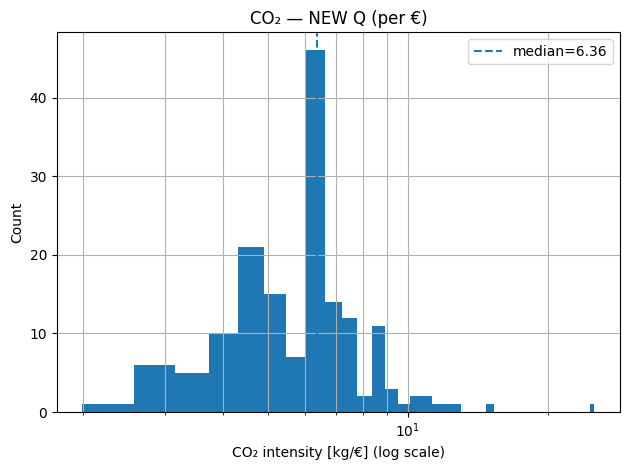

CO₂ — NEW Q (per €) stats: {'n': 163, 'min': 1.9973067464260632, 'p50': 6.363591272545295, 'p90': 8.818532442173476, 'max': 25.16498509034529, 'mean': 6.363591272545295}


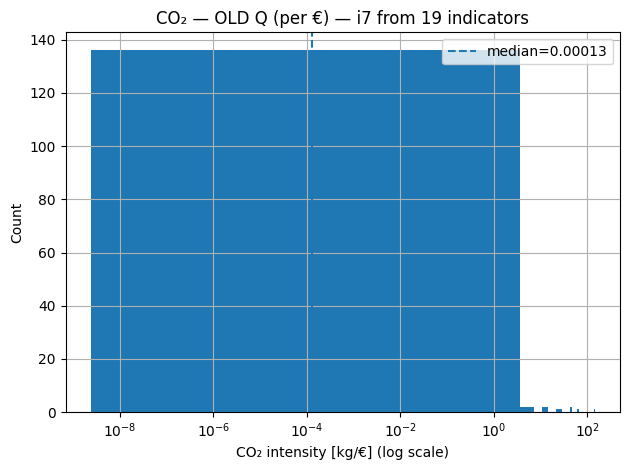

CO₂ — OLD Q (per €) — i7 from 19 indicators stats: {'n': 146, 'min': 2.4081116608074352e-09, 'p50': 0.000129506175598, 'p90': 0.20703986598361254, 'max': 146.05783693076663, 'mean': 2.7192569528472736}


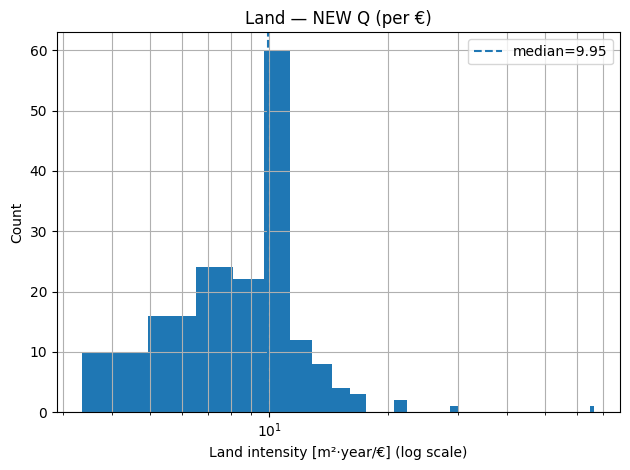

Land — NEW Q (per €) stats: {'n': 163, 'min': 3.3692173306153603, 'p50': 9.950919085294927, 'p90': 13.115032485414728, 'max': 66.49463693919945, 'mean': 9.950919085294926}


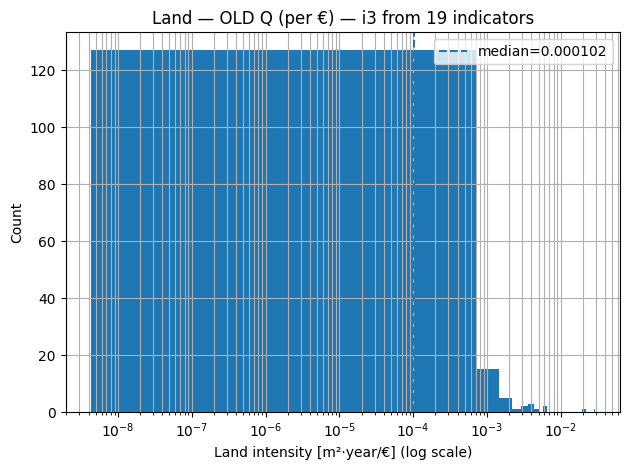

Land — OLD Q (per €) — i3 from 19 indicators stats: {'n': 159, 'min': 4.3023228512536706e-09, 'p50': 0.0001016245586814, 'p90': 0.0015099184361906243, 'max': 0.0289331107361576, 'mean': 0.000948496289612879}


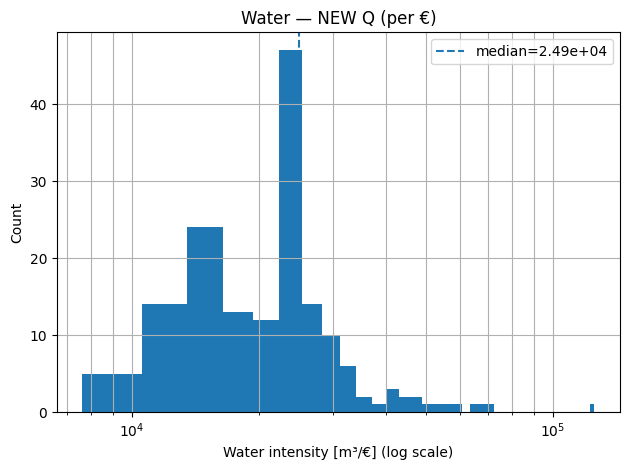

Water — NEW Q (per €) stats: {'n': 163, 'min': 7627.276849424733, 'p50': 24882.753403821887, 'p90': 34982.914662821015, 'max': 125371.72209233652, 'mean': 24882.75340382189}


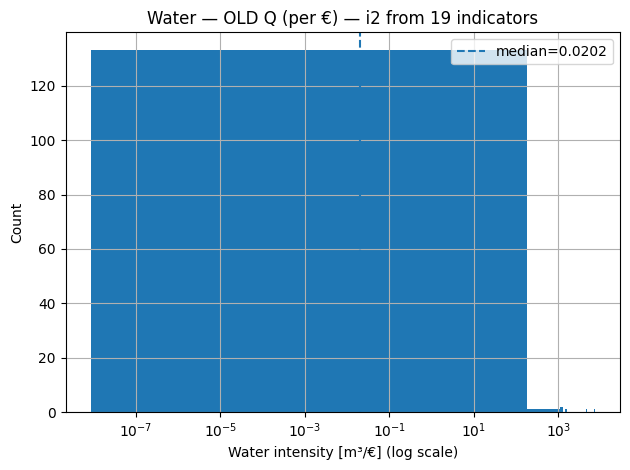

Water — OLD Q (per €) — i2 from 19 indicators stats: {'n': 143, 'min': 8.650252557953995e-09, 'p50': 0.0202070493482523, 'p90': 4.4105498738430295, 'max': 7362.476937200538, 'mean': 138.73296337546336}


In [47]:
# ============================================================
# Distributions from Q MATRICES based on fixed indicator indices
# Use EXACT mapping for OLD 19-indicator baseline:
#   IDX = {"CO2": 7, "Land": 3, "Water": 2}
#
# NEW  = Q_new (regionless, per €)  -> *.npy (3×S with rows [CO2, Land, Water])
#                                     or *.csv with columns [CO2, Land, Water]
# OLD  = Q_all19_global_regionless.csv (per €, 19×S) -> pick i7, i3, i2
#
# Plots (log x-scale):
#   1) CO2 NEW, 2) CO2 OLD (i7)
#   3) Land NEW, 4) Land OLD (i3)
#   5) Water NEW, 6) Water OLD (i2)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Constants ----------
ROOT = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")
HDIR = ROOT / "harmonized_micro"
HDIR.mkdir(parents=True, exist_ok=True)

# Fixed indicator indices for the 19-indicator OLD baseline
IDX = {"CO2": 7, "Land": 3, "Water": 2}

# ---------- Helpers ----------
def first_existing(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def keep_positive(x):
    x = np.asarray(x, dtype=float)
    return x[np.isfinite(x) & (x > 0)]

def qnew_vectors():
    """
    Return NEW Q vectors (CO2, Land, Water) as 1D numpy arrays (length = #sectors).
    Prefers *.npy saved as (3, S). Falls back to *.csv with named columns.
    Units: per €, already harmonized in earlier steps.
    """
    npy = first_existing([
        HDIR / "Q_new_sector_aligned_imputed.npy",
        HDIR / "Q_new_sector_aligned.npy",
    ])
    if npy:
        arr = np.load(npy)
        if arr.shape[0] != 3:
            raise ValueError(f"Q_new array must be (3, S); got {arr.shape}")
        return arr[0, :], arr[1, :], arr[2, :]
    csv = first_existing([
        HDIR / "Q_new_sector_aligned_imputed.csv",
        HDIR / "Q_new_sector_aligned.csv",
    ])
    if not csv:
        raise FileNotFoundError("Could not find Q_new (npy/csv).")
    df = pd.read_csv(csv)
    return (
        pd.to_numeric(df["CO2"], errors="coerce").to_numpy(),
        pd.to_numeric(df["Land"], errors="coerce").to_numpy(),
        pd.to_numeric(df["Water"], errors="coerce").to_numpy(),
    )

def qold_vectors_from_19(idx_map):
    """
    Return OLD Q vectors (CO2, Land, Water) from the 19-indicator regionless baseline,
    selecting fixed indices given in idx_map (e.g., {'CO2':7,'Land':3,'Water':2}).
    """
    csv19 = first_existing([
        HDIR / "Q_all19_global_regionless.csv",
        Path("/mnt/data/Q_all19_global_regionless.csv"),
    ])
    if not csv19:
        raise FileNotFoundError("Q_all19_global_regionless.csv not found.")
    df = pd.read_csv(csv19)
    # Expect columns i0..i18 (per €) + sector_index
    def col(i):
        c = f"i{i}"
        if c not in df.columns:
            raise KeyError(f"Missing column '{c}' in {csv19.name}")
        return pd.to_numeric(df[c], errors="coerce").to_numpy()
    return col(idx_map["CO2"]), col(idx_map["Land"]), col(idx_map["Water"])

def stats(x):
    x = pd.Series(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.empty:
        return dict(n=0, min=np.nan, p50=np.nan, p90=np.nan, max=np.nan, mean=np.nan)
    return dict(
        n=int(x.size), min=float(x.min()), p50=float(x.median()),
        p90=float(x.quantile(0.90)), max=float(x.max()), mean=float(x.mean())
    )

def plot_hist(data, title, xlabel):
    """
    Single histogram with log x-axis; uses positive values only.
    """
    dpos = keep_positive(data)
    s = stats(dpos)
    plt.figure()
    plt.hist(dpos, bins=40)
    plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    if np.isfinite(s["p50"]):
        plt.axvline(s["p50"], linestyle="--", label=f"median={s['p50']:.3g}")
        plt.legend()
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()
    print(title, "stats:", s)

# ---------- Load vectors ----------
co2_new, land_new, water_new = qnew_vectors()
co2_old, land_old, water_old = qold_vectors_from_19(IDX)

# ---------- CO2 ----------
plot_hist(co2_new,  "CO₂ — NEW Q (per €)",  "CO₂ intensity [kg/€] (log scale)")
plot_hist(co2_old,  f"CO₂ — OLD Q (per €) — i{IDX['CO2']} from 19 indicators",  "CO₂ intensity [kg/€] (log scale)")

# ---------- LAND ----------
plot_hist(land_new, "Land — NEW Q (per €)",  "Land intensity [m²·year/€] (log scale)")
plot_hist(land_old, f"Land — OLD Q (per €) — i{IDX['Land']} from 19 indicators", "Land intensity [m²·year/€] (log scale)")

# ---------- WATER ----------
plot_hist(water_new, "Water — NEW Q (per €)",  "Water intensity [m³/€] (log scale)")
plot_hist(water_old, f"Water — OLD Q (per €) — i{IDX['Water']} from 19 indicators", "Water intensity [m³/€] (log scale)")


**IF TO MULTYPLY Q_OLD VALUES BY 100.000 THEN THE RESULTS BECOME OKEYISH**


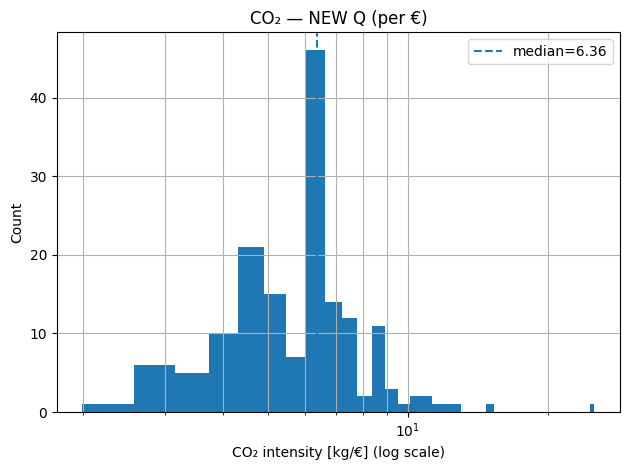

CO₂ — NEW Q (per €) stats: {'n': 163, 'min': 1.9973067464260632, 'p50': 6.363591272545295, 'p90': 8.818532442173476, 'max': 25.16498509034529, 'mean': 6.363591272545295}


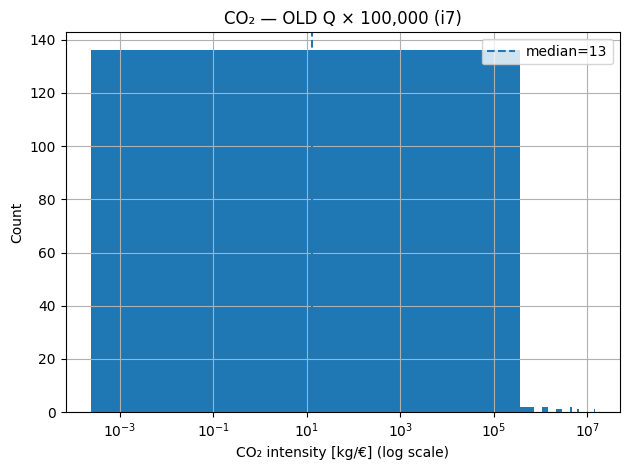

CO₂ — OLD Q × 100,000 (i7) stats: {'n': 146, 'min': 0.0002408111660807435, 'p50': 12.9506175598, 'p90': 20703.986598361254, 'max': 14605783.693076663, 'mean': 271925.6952847274}


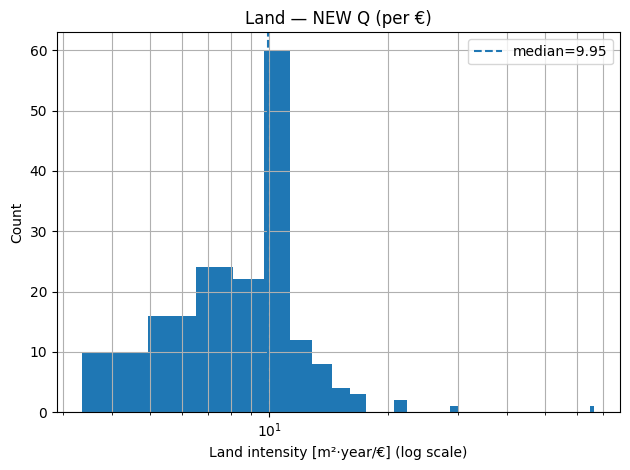

Land — NEW Q (per €) stats: {'n': 163, 'min': 3.3692173306153603, 'p50': 9.950919085294927, 'p90': 13.115032485414728, 'max': 66.49463693919945, 'mean': 9.950919085294926}


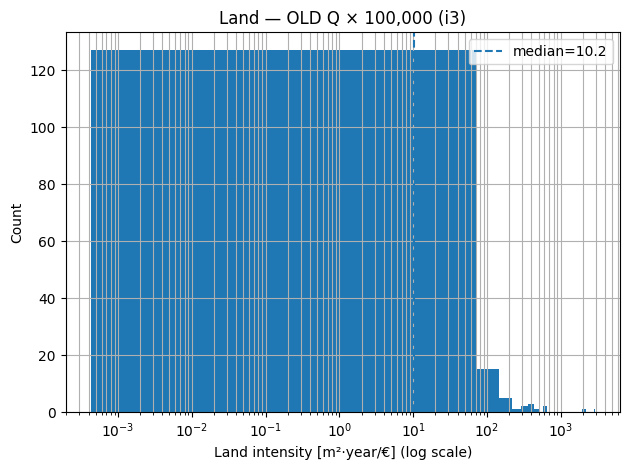

Land — OLD Q × 100,000 (i3) stats: {'n': 159, 'min': 0.00043023228512536707, 'p50': 10.16245586814, 'p90': 150.99184361906242, 'max': 2893.31107361576, 'mean': 94.8496289612879}


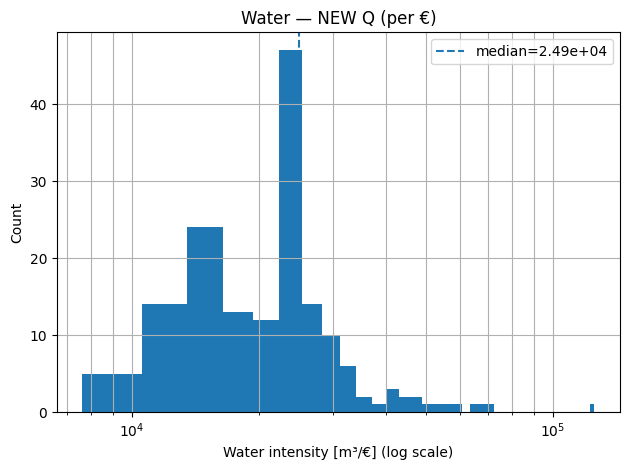

Water — NEW Q (per €) stats: {'n': 163, 'min': 7627.276849424733, 'p50': 24882.753403821887, 'p90': 34982.914662821015, 'max': 125371.72209233652, 'mean': 24882.75340382189}


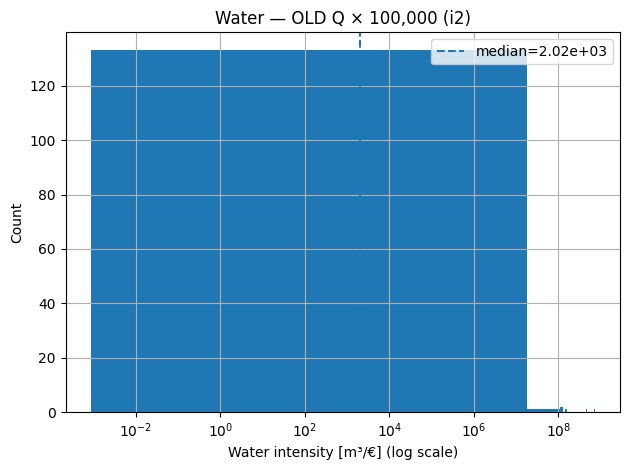

Water — OLD Q × 100,000 (i2) stats: {'n': 143, 'min': 0.0008650252557953995, 'p50': 2020.7049348252299, 'p90': 441054.98738430295, 'max': 736247693.7200538, 'mean': 13873296.337546334}


In [48]:
# ============================================================
# Plot distributions from Q MATRICES with OLD scaled by 1e5
#   • Use fixed 19-indicator indices: IDX = {"CO2":7, "Land":3, "Water":2}
#   • NEW  = Q_new (regionless, per €)  -> *.npy (3×S) or *.csv [CO2, Land, Water]
#   • OLD  = Q_all19_global_regionless.csv (per €, 19×S) -> pick i7, i3, i2, then ×100000
#   • Plots: CO2/Land/Water for NEW and OLD×1e5 (log x-scale)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Constants ----------
ROOT = Path("/content/drive/MyDrive/MRIO_3/SmartFootPrintAI")
HDIR = ROOT / "harmonized_micro"
HDIR.mkdir(parents=True, exist_ok=True)

IDX = {"CO2": 7, "Land": 3, "Water": 2}   # fixed indices in 19-indicator baseline
OLD_SCALE = 100_000                       # multiply OLD by 1e5 before plotting

# ---------- Helpers ----------
def first_existing(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def keep_positive(x):
    x = np.asarray(x, dtype=float)
    return x[np.isfinite(x) & (x > 0)]

def stats(x):
    x = pd.Series(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.empty:
        return dict(n=0, min=np.nan, p50=np.nan, p90=np.nan, max=np.nan, mean=np.nan)
    return dict(
        n=int(x.size), min=float(x.min()), p50=float(x.median()),
        p90=float(x.quantile(0.90)), max=float(x.max()), mean=float(x.mean())
    )

def plot_hist(data, title, xlabel):
    dpos = keep_positive(data)
    s = stats(dpos)
    plt.figure()
    plt.hist(dpos, bins=40)
    plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    if np.isfinite(s["p50"]):
        plt.axvline(s["p50"], linestyle="--", label=f"median={s['p50']:.3g}")
        plt.legend()
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()
    print(title, "stats:", s)

def load_qnew_vectors():
    """
    Return NEW vectors (co2_new, land_new, water_new) as 1D arrays (length = #sectors).
    Prefers *.npy saved as (3, S). Falls back to *.csv with named columns.
    Units: per €.
    """
    npy = first_existing([
        HDIR / "Q_new_sector_aligned_imputed.npy",
        HDIR / "Q_new_sector_aligned.npy",
    ])
    if npy:
        arr = np.load(npy)
        if arr.shape[0] != 3:
            raise ValueError(f"Q_new array must be (3, S); got {arr.shape}")
        return arr[0, :], arr[1, :], arr[2, :]
    csv = first_existing([
        HDIR / "Q_new_sector_aligned_imputed.csv",
        HDIR / "Q_new_sector_aligned.csv",
    ])
    if not csv:
        raise FileNotFoundError("Could not find Q_new (npy/csv).")
    df = pd.read_csv(csv)
    return (
        pd.to_numeric(df["CO2"], errors="coerce").to_numpy(),
        pd.to_numeric(df["Land"], errors="coerce").to_numpy(),
        pd.to_numeric(df["Water"], errors="coerce").to_numpy(),
    )

def load_qold_vectors_from_19(idx_map):
    """
    Return OLD vectors (co2_old, land_old, water_old) from the 19-indicator baseline (per €),
    selecting fixed indices in idx_map; then multiply ALL OLD values by OLD_SCALE.
    """
    csv19 = first_existing([
        HDIR / "Q_all19_global_regionless.csv",
        Path("/mnt/data/Q_all19_global_regionless.csv"),
    ])
    if not csv19:
        raise FileNotFoundError("Q_all19_global_regionless.csv not found.")
    df = pd.read_csv(csv19)
    def col(i):
        c = f"i{i}"
        if c not in df.columns:
            raise KeyError(f"Missing column '{c}' in {csv19.name}")
        return pd.to_numeric(df[c], errors="coerce").to_numpy()
    co2 = col(idx_map["CO2"]) * OLD_SCALE
    land = col(idx_map["Land"]) * OLD_SCALE
    water = col(idx_map["Water"]) * OLD_SCALE
    return co2, land, water

# ---------- Load data ----------
co2_new, land_new, water_new = load_qnew_vectors()
co2_old_scaled, land_old_scaled, water_old_scaled = load_qold_vectors_from_19(IDX)

# ---------- Plots ----------
# CO2
plot_hist(co2_new,         "CO₂ — NEW Q (per €)",                  "CO₂ intensity [kg/€] (log scale)")
plot_hist(co2_old_scaled,  f"CO₂ — OLD Q × {OLD_SCALE:,} (i{IDX['CO2']})",  "CO₂ intensity [kg/€] (log scale)")

# Land
plot_hist(land_new,        "Land — NEW Q (per €)",                  "Land intensity [m²·year/€] (log scale)")
plot_hist(land_old_scaled, f"Land — OLD Q × {OLD_SCALE:,} (i{IDX['Land']})","Land intensity [m²·year/€] (log scale)")

# Water
plot_hist(water_new,        "Water — NEW Q (per €)",                 "Water intensity [m³/€] (log scale)")
plot_hist(water_old_scaled, f"Water — OLD Q × {OLD_SCALE:,} (i{IDX['Water']})","Water intensity [m³/€] (log scale)")
